In [2]:
import os
import json
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import osmnx as ox

WORLDPOP_ARM_2020_PPP = (
    "https://data.worldpop.org/GIS/Population/Individual_countries/ARM/"
    "Armenia_100m_Population/ARM_ppp_v2c_2020.tif"
)

def download_file(url: str, out_path: str, chunk_size: int = 1024 * 1024) -> str:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    if os.path.exists(out_path) and os.path.getsize(out_path) > 0:
        return out_path

    with requests.get(url, stream=True, timeout=120) as r:
        r.raise_for_status()
        with open(out_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
    return out_path

import geopandas as gpd
import osmnx as ox

import geopandas as gpd
import osmnx as ox
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping

def get_yerevan_boundary() -> gpd.GeoDataFrame:
    gdf = ox.geocode_to_gdf("Yerevan, Armenia")
    gdf = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
    if gdf.empty:
        raise RuntimeError("Could not fetch a polygon boundary for Yerevan from OSM.")

    # Shapely 2 / GeoPandas newer versions: union_all() preferred
    try:
        geom = gdf.geometry.union_all()
    except Exception:
        geom = gdf.geometry.unary_union  # fallback for older versions

    return gpd.GeoDataFrame(geometry=[geom], crs=gdf.crs)

def clip_raster_to_polygon(in_tif: str, poly_gdf: gpd.GeoDataFrame, out_tif: str) -> str:
    with rasterio.open(in_tif) as src:
        poly = poly_gdf.to_crs(src.crs)
        geom = poly.geometry.iloc[0]          # shapely Polygon/MultiPolygon
        geoms = [mapping(geom)]              # GeoJSON-like dict

        out_image, out_transform = mask(src, geoms, crop=True, filled=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        import os
        os.makedirs(os.path.dirname(out_tif), exist_ok=True)
        with rasterio.open(out_tif, "w", **out_meta) as dst:
            dst.write(out_image)

    return out_tif


def reproject_to_utm(in_tif: str, out_tif: str, dst_crs: str = "EPSG:32638") -> str:
    # EPSG:32638 = UTM zone 38N (fits Yerevan area well)
    os.makedirs(os.path.dirname(out_tif), exist_ok=True)

    with rasterio.open(in_tif) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height
        })

        with rasterio.open(out_tif, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )
    return out_tif

def raster_to_points_table(in_tif: str, out_csv: str) -> str:
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)

    with rasterio.open(in_tif) as src:
        arr = src.read(1)
        nodata = src.nodata
        mask_valid = np.ones(arr.shape, dtype=bool)
        if nodata is not None:
            mask_valid &= (arr != nodata)
        mask_valid &= np.isfinite(arr)

        rows, cols = np.where(mask_valid)
        xs, ys = rasterio.transform.xy(src.transform, rows, cols, offset="center")
        pop = arr[rows, cols].astype(float)

        df = pd.DataFrame({"x": xs, "y": ys, "pop": pop})
        df.to_csv(out_csv, index=False)

    return out_csv

if __name__ == "__main__":
    data_dir = "data/yerevan_pop"
    raw_tif = os.path.join(data_dir, "ARM_ppp_v2c_2020.tif")
    clipped_tif = os.path.join(data_dir, "yerevan_ppp_2020_clipped_wgs84.tif")
    clipped_utm_tif = os.path.join(data_dir, "yerevan_ppp_2020_clipped_utm38n.tif")
    grid_csv = os.path.join(data_dir, "yerevan_population_grid_points.csv")

    print("1) Download WorldPop raster...")
    download_file(WORLDPOP_ARM_2020_PPP, raw_tif)

    print("2) Get Yerevan boundary from OSM...")
    yerevan_poly = get_yerevan_boundary()

    print("3) Clip raster to Yerevan boundary...")
    clip_raster_to_polygon(raw_tif, yerevan_poly, clipped_tif)

    print("4) Reproject clipped raster to UTM (meters) for clean distances/areas...")
    reproject_to_utm(clipped_tif, clipped_utm_tif, dst_crs="EPSG:32638")

    print("5) Export grid cells (centroids) + population to CSV (this is your N(x) grid)...")
    raster_to_points_table(clipped_utm_tif, grid_csv)

    print("Done.")
    print("Clipped raster:", clipped_utm_tif)
    print("Grid CSV:", grid_csv)


1) Download WorldPop raster...
2) Get Yerevan boundary from OSM...
3) Clip raster to Yerevan boundary...
4) Reproject clipped raster to UTM (meters) for clean distances/areas...
5) Export grid cells (centroids) + population to CSV (this is your N(x) grid)...
Done.
Clipped raster: data/yerevan_pop\yerevan_ppp_2020_clipped_utm38n.tif
Grid CSV: data/yerevan_pop\yerevan_population_grid_points.csv


In [10]:
clipped_utm_tif

'data/yerevan_pop\\yerevan_ppp_2020_clipped_utm38n.tif'

In [8]:
yerevan_poly

geometry
0  MULTIPOLYGON (((44.36211 40.1471, 44.36212 40....

In [4]:
import geopandas as gpd
import osmnx as ox

def get_yerevan_boundary() -> gpd.GeoDataFrame:
    gdf = ox.geocode_to_gdf("Yerevan, Armenia")
    gdf = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
    if gdf.empty:
        raise RuntimeError("Could not fetch a polygon boundary for Yerevan from OSM.")
    try:
        geom = gdf.geometry.union_all()
    except Exception:
        geom = gdf.geometry.unary_union
    return gpd.GeoDataFrame(geometry=[geom], crs=gdf.crs)

yerevan = get_yerevan_boundary()
import osmnx as ox
import geopandas as gpd

# Make requests more reliable (OSM can rate-limit)
ox.settings.use_cache = True
ox.settings.log_console = True
ox.settings.timeout = 180

BUSINESS_TAGS = {
    "shop": True,          # retail stores
    "office": True,        # offices
    "craft": True,         # workshops, small production
    "industrial": True,    # industrial landuse / industrial sites
    "amenity": [
        "restaurant","cafe","bar","fast_food",
        "bank","atm",
        "pharmacy","clinic","hospital","dentist","doctors",
        "school","university","college","kindergarten",
        "fuel",
        "cinema","theatre","nightclub",
        "marketplace"
    ],
    "tourism": ["hotel","hostel","guest_house","museum"],
    "building": ["commercial","industrial","retail","office"]
}

# Fetch POIs and polygons within the boundary
gdf_raw = ox.features_from_polygon(yerevan.geometry.iloc[0], BUSINESS_TAGS)
gdf_raw.head()
import numpy as np

def businesses_to_points(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    gdf = gdf.copy()
    gdf = gdf[gdf.geometry.notnull()]

    # Reproject to meters before taking centroids (important)
    gdf_m = gdf.to_crs("EPSG:32638")  # UTM 38N for Yerevan

    geom_type = gdf_m.geometry.geom_type

    points = gdf_m[geom_type == "Point"].copy()
    polys  = gdf_m[geom_type.isin(["Polygon", "MultiPolygon"])].copy()

    # For polygons, use representative_point (always inside) or centroid
    # representative_point is safer for weird shapes
    polys["geometry"] = polys.geometry.representative_point()

    out = gpd.GeoDataFrame(
        pd.concat([points, polys], ignore_index=True),
        crs=gdf_m.crs
    )

    # Keep only a few useful columns + geometry
    keep_cols = []
    for c in ["name","amenity","shop","office","craft","industrial","tourism","building"]:
        if c in out.columns:
            keep_cols.append(c)
    out = out[keep_cols + ["geometry"]].copy()

    # Optional: create a simple "category" field
    def pick_category(row):
        for k in ["shop","office","craft","industrial","amenity","tourism","building"]:
            v = row.get(k, None)
            if v is not None and (not (isinstance(v, float) and np.isnan(v))):
                if v is True:
                    return k
                return f"{k}:{v}"
        return "other"

    out["category"] = out.apply(pick_category, axis=1)
    return out

biz_points = businesses_to_points(gdf_raw)
biz_points.head(), len(biz_points)
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box

def make_grid(bounds, cell_size_m: int, crs: str):
    minx, miny, maxx, maxy = bounds
    xs = np.arange(minx, maxx + cell_size_m, cell_size_m)
    ys = np.arange(miny, maxy + cell_size_m, cell_size_m)

    cells = []
    for x in xs[:-1]:
        for y in ys[:-1]:
            cells.append(box(x, y, x + cell_size_m, y + cell_size_m))

    grid = gpd.GeoDataFrame({"geometry": cells}, crs=crs)
    grid["cell_id"] = np.arange(len(grid))
    return grid

# Ensure boundary in meters CRS
yerevan_m = yerevan.to_crs("EPSG:32638")
grid = make_grid(yerevan_m.total_bounds, cell_size_m=500, crs="EPSG:32638")

# Clip grid to city boundary (keeps only intersecting cells)
grid = gpd.overlay(grid, yerevan_m, how="intersection")
grid["cell_area_m2"] = grid.area

# Spatial join: count businesses per grid cell
join = gpd.sjoin(biz_points, grid[["cell_id","geometry"]], predicate="within", how="left")
counts = join.groupby("cell_id").size().rename("biz_count").reset_index()

grid = grid.merge(counts, on="cell_id", how="left")
grid["biz_count"] = grid["biz_count"].fillna(0).astype(int)

# Density per km²
grid["biz_density_per_km2"] = grid["biz_count"] / (grid["cell_area_m2"] / 1_000_000)

grid.head()
biz_points.to_file("data/yerevan_business_points.gpkg", layer="business_points", driver="GPKG")
grid.to_file("data/yerevan_business_density_grid.gpkg", layer="biz_density_grid", driver="GPKG")

# also as CSV with grid centroids:
grid_centroids = grid.copy()
grid_centroids["geometry"] = grid_centroids.geometry.centroid
grid_centroids["x"] = grid_centroids.geometry.x
grid_centroids["y"] = grid_centroids.geometry.y
grid_centroids.drop(columns="geometry").to_csv("data/yerevan_business_density_grid.csv", index=False)


           pop_sum  pop_density_per_km2    biz_count  biz_density_per_km2
count  1036.000000          1036.000000  1036.000000          1036.000000
mean    997.955732          4319.462305    12.430502            50.741844
std     646.582465          2856.168298    35.042831           140.293414
min       0.000000             0.000000     0.000000             0.000000
25%     421.306900          2613.110107     0.000000             0.000000
50%    1096.603027          4506.695801     0.000000             0.000000
75%    1419.123138          5851.570312     8.000000            32.000000
max    2701.879150         46813.847342   418.000000          1672.000000


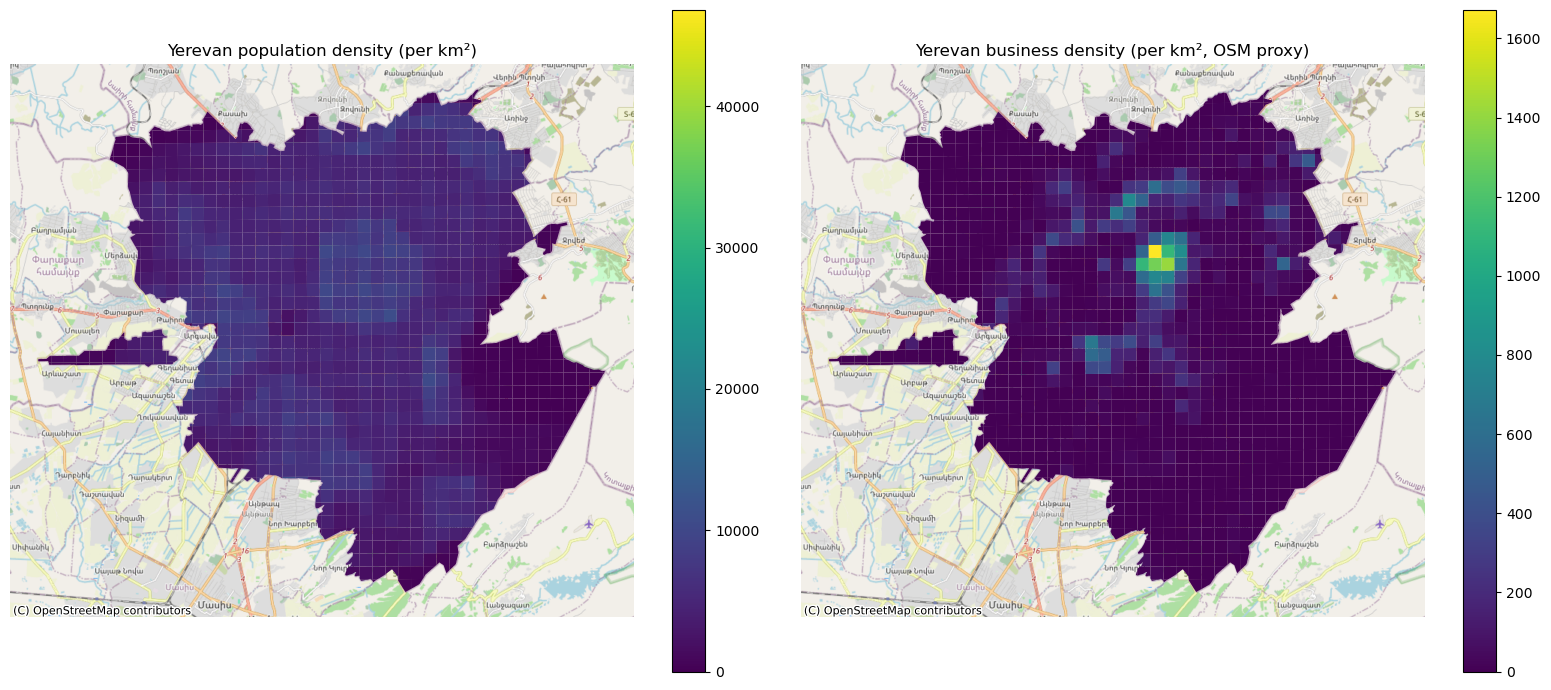

In [16]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt

# Optional basemap
import contextily as ctx

# Paths (adjust if yours differ)
POP_RASTER = "data/yerevan_pop/yerevan_ppp_2020_clipped_utm38n.tif"
BIZ_GRID_GPKG = "data/yerevan_business_density_grid.gpkg"   # created earlier
BIZ_LAYER = "biz_density_grid"

# Load business density grid (must be in EPSG:32638 like in the earlier code)
grid = gpd.read_file(BIZ_GRID_GPKG, layer=BIZ_LAYER)

# Read raster nodata safely
with rasterio.open(POP_RASTER) as src:
    nodata = src.nodata

# Zonal sum of population in each grid cell
stats = zonal_stats(
    grid,
    POP_RASTER,
    stats=["sum"],
    nodata=nodata,
    all_touched=False  # set True if you want to include pixels that touch a cell boundary
)

grid["pop_sum"] = [s["sum"] if s["sum"] is not None else 0 for s in stats]

# Densities per km2
grid["area_km2"] = grid.area / 1_000_000
grid["pop_density_per_km2"] = grid["pop_sum"] / grid["area_km2"]

# Also keep business density if present
# grid already has biz_density_per_km2 from the earlier script
print(grid[["pop_sum", "pop_density_per_km2", "biz_count", "biz_density_per_km2"]].describe())

# Plot side-by-side with basemap
grid_3857 = grid.to_crs(epsg=3857)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

ax0 = axes[0]
grid_3857.plot(
    column="pop_density_per_km2",
    ax=ax0,
    legend=True,
    linewidth=0,
)
ctx.add_basemap(ax0, source=ctx.providers.OpenStreetMap.Mapnik)
ax0.set_title("Yerevan population density (per km²)")
ax0.set_axis_off()

ax1 = axes[1]
grid_3857.plot(
    column="biz_density_per_km2",
    ax=ax1,
    legend=True,
    linewidth=0,
)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_title("Yerevan business density (per km², OSM proxy)")
ax1.set_axis_off()

plt.tight_layout()
plt.show()


1) Download Armstat PDF...
2) Extract district price table...
            district price_2021_amd_m2  price_2022_amd_m2
0            Kentron           1122011                870
1            Arabkir             98499                900
2     Qanaqer-Zeytun             48193                943
3           Nor-Norq             61616                643
4               Avan             25172                444
5            Erebuni             40954                416
6          Shengavit             71986                815
7          Davtashen             30993                449
8           Ajapnyak             58176                 37
9   Malatia-Sebastia             69227                205
10        Nubarashen               446                453
3) Fetch Yerevan district polygons from OSM...
4) Attach prices to a grid...
5) Convert to implied rent (choose yield)...
6) Plot...


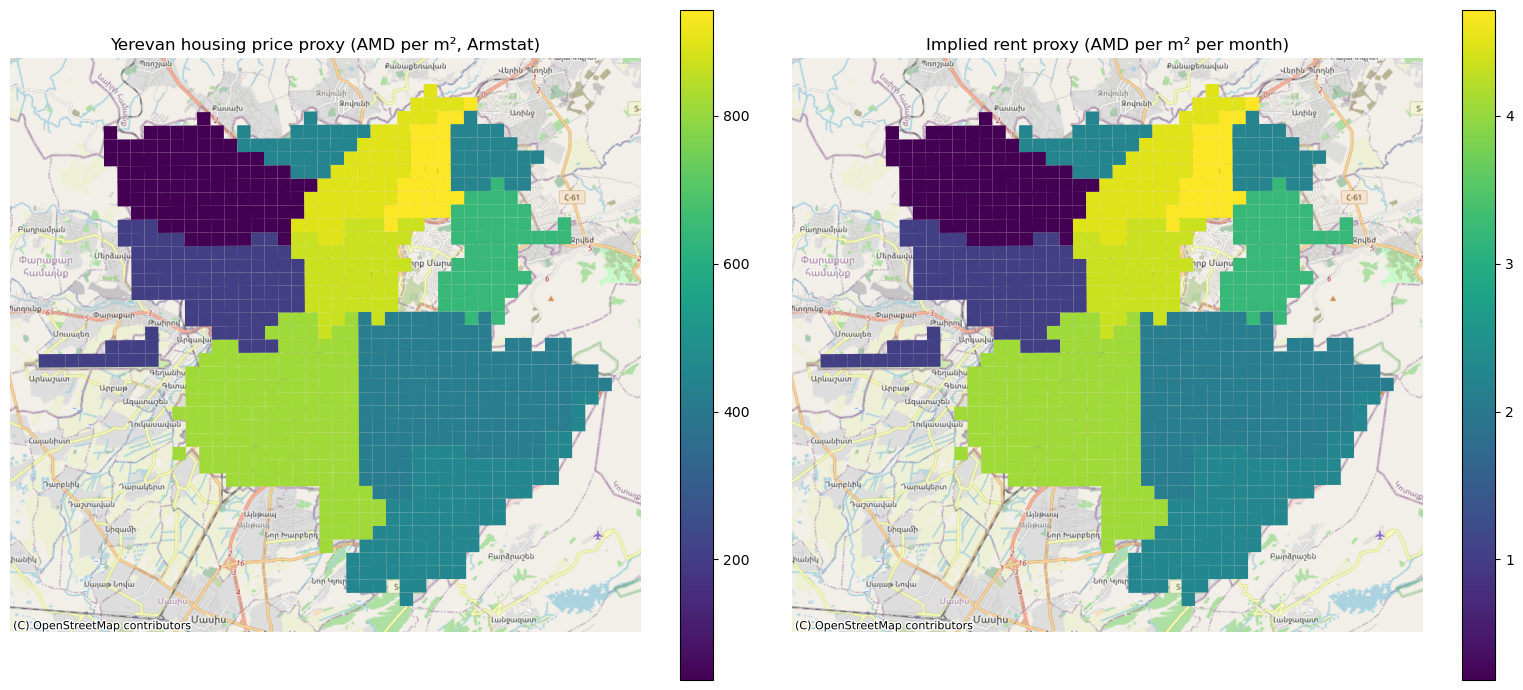

In [18]:
import re
import os
import requests
import pdfplumber
import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx

from shapely.geometry import box

# Armstat Housing Stock PDF that includes the district table (Yerevan avg market price per m2)
ARMSTAT_PDF_URL = "https://armstat.am/file/article/housing_stock__2022_2_en.pdf"

YEREVAN_DISTRICTS = [
    "Kentron",
    "Arabkir",
    "Qanaqer-Zeytun",
    "Nor-Norq",          # sometimes spelled Nor Nork in English sources
    "Avan",
    "Erebuni",
    "Shengavit",
    "Davtashen",
    "Ajapnyak",
    "Malatia-Sebastia",
    "Nubarashen"
]

def download_file(url: str, out_path: str) -> str:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    if os.path.exists(out_path) and os.path.getsize(out_path) > 0:
        return out_path
    r = requests.get(url, timeout=120)
    r.raise_for_status()
    with open(out_path, "wb") as f:
        f.write(r.content)
    return out_path

def extract_yerevan_price_table(pdf_path: str) -> pd.DataFrame:
    """
    Extracts the table:
      Average market prices ... by administrative districts
    Returns dataframe with columns: district, price_2021_amd_m2, price_2022_amd_m2
    """
    rows = []
    district_set = set(YEREVAN_DISTRICTS)

    # Regex to catch two numbers with spaces as thousand separators, e.g. "633 000 737 800"
    num_pat = re.compile(r"(\d[\d\s]{2,})\s+(\d[\d\s]{2,})$")

    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text = page.extract_text() or ""
            for line in text.splitlines():
                line = line.strip()

                # Try match district at start
                # Some PDFs use non-breaking spaces; normalize
                line_norm = " ".join(line.replace("\xa0", " ").split())

                for d in YEREVAN_DISTRICTS:
                    if line_norm.startswith(d):
                        # Remove district name prefix
                        rest = line_norm[len(d):].strip()
                        m = num_pat.search(rest)
                        if not m:
                            continue
                        p2021 = int(m.group(1).replace(" ", ""))
                        p2022 = int(m.group(2).replace(" ", ""))
                        rows.append({"district": d, "price_2021_amd_m2": p2021, "price_2022_amd_m2": p2022})
                        break

    df = pd.DataFrame(rows).drop_duplicates(subset=["district"])
    # Some PDFs spell Nor Nork differently; patch if needed
    if "Nor-Norq" not in df["district"].values and "Nor Nork" in df["district"].values:
        df.loc[df["district"] == "Nor Nork", "district"] = "Nor-Norq"

    # sanity
    missing = district_set - set(df["district"].tolist())
    if missing:
        print("Warning: missing districts from extracted table:", missing)

    return df

def get_district_polygon(name: str) -> gpd.GeoDataFrame:
    # Try a couple query variants to get admin boundary polygons
    queries = [
        f"{name}, Yerevan, Armenia",
        f"{name} district, Yerevan, Armenia"
    ]
    for q in queries:
        try:
            gdf = ox.geocode_to_gdf(q)
            gdf = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
            if not gdf.empty:
                try:
                    geom = gdf.geometry.union_all()
                except Exception:
                    geom = gdf.geometry.unary_union
                return gpd.GeoDataFrame({"district":[name], "geometry":[geom]}, crs=gdf.crs)
        except Exception:
            pass
    raise RuntimeError(f"Could not get polygon for district: {name}")

def build_district_gdf(price_df: pd.DataFrame) -> gpd.GeoDataFrame:
    parts = []
    for d in price_df["district"].tolist():
        parts.append(get_district_polygon(d))
    gdf = pd.concat(parts, ignore_index=True)
    gdf = gdf.merge(price_df, on="district", how="left")
    # project to UTM 38N for area/grid work
    return gdf.to_crs("EPSG:32638")

def make_grid(bounds, cell_size_m: int, crs: str):
    minx, miny, maxx, maxy = bounds
    xs = np.arange(minx, maxx + cell_size_m, cell_size_m)
    ys = np.arange(miny, maxy + cell_size_m, cell_size_m)
    cells = []
    for x in xs[:-1]:
        for y in ys[:-1]:
            cells.append(box(x, y, x + cell_size_m, y + cell_size_m))
    grid = gpd.GeoDataFrame({"geometry": cells}, crs=crs)
    grid["cell_id"] = np.arange(len(grid))
    return grid

def attach_price_to_grid(districts_utm: gpd.GeoDataFrame, cell_size_m: int = 500) -> gpd.GeoDataFrame:
    grid = make_grid(districts_utm.total_bounds, cell_size_m=cell_size_m, crs=districts_utm.crs)
    # join grid to districts by centroid-in-polygon (stable)
    grid_cent = grid.copy()
    grid_cent["geometry"] = grid_cent.geometry.centroid
    joined = gpd.sjoin(grid_cent, districts_utm[["district","price_2022_amd_m2","geometry"]], predicate="within", how="left")
    out = grid.merge(joined[["cell_id","district","price_2022_amd_m2"]], on="cell_id", how="left")
    return out

def add_implied_rent(out_grid: gpd.GeoDataFrame, gross_yield_annual: float = 0.06) -> gpd.GeoDataFrame:
    """
    Converts price per m2 to implied monthly rent per m2 using:
      rent_m2_month = price_m2 * yield / 12
    """
    g = out_grid.copy()
    g["rent_implied_amd_m2_month"] = g["price_2022_amd_m2"] * gross_yield_annual / 12.0
    return g

def plot_price_and_implied_rent(grid_utm: gpd.GeoDataFrame):
    g3857 = grid_utm.to_crs(epsg=3857)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    ax0 = axes[0]
    g3857.plot(column="price_2022_amd_m2", ax=ax0, legend=True, linewidth=0)
    ctx.add_basemap(ax0, source=ctx.providers.OpenStreetMap.Mapnik)
    ax0.set_title("Yerevan housing price proxy (AMD per m², Armstat)")
    ax0.set_axis_off()

    ax1 = axes[1]
    g3857.plot(column="rent_implied_amd_m2_month", ax=ax1, legend=True, linewidth=0)
    ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
    ax1.set_title("Implied rent proxy (AMD per m² per month)")
    ax1.set_axis_off()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    out_dir = "data/yerevan_rent_proxy"
    pdf_path = os.path.join(out_dir, "housing_stock__2022_2_en.pdf")

    print("1) Download Armstat PDF...")
    download_file(ARMSTAT_PDF_URL, pdf_path)

    print("2) Extract district price table...")
    prices = extract_yerevan_price_table(pdf_path)
    print(prices)

    print("3) Fetch Yerevan district polygons from OSM...")
    districts = build_district_gdf(prices)

    print("4) Attach prices to a grid...")
    grid = attach_price_to_grid(districts, cell_size_m=500)

    print("5) Convert to implied rent (choose yield)...")
    grid = add_implied_rent(grid, gross_yield_annual=0.06)

    print("6) Plot...")
    plot_price_and_implied_rent(grid)

    # Save for later joins with N(x) and M(x)
    os.makedirs(out_dir, exist_ok=True)
    grid.to_file(os.path.join(out_dir, "yerevan_price_rent_proxy_grid.gpkg"), layer="rent_proxy_grid", driver="GPKG")
    grid.drop(columns="geometry").to_csv(os.path.join(out_dir, "yerevan_price_rent_proxy_grid.csv"), index=False)


Columns: ['construction_type', 'new_construction', 'elevator', 'floors_in_the_building', 'floor_area', 'number_of_rooms', 'number_of_bathrooms', 'ceiling_height', 'floor', 'balcony', 'furniture', 'renovation', 'price', 'currency', 'datetime', 'reg_id', 'Latitude', 'Longitude']
Using columns:
 lat: Latitude
 lon: Longitude
 price: price
 area: None
 currency: currency
Listings inside Yerevan: 61133
Saved: data/yerevan_rent_proxy/rent_proxy_from_sale_grid.gpkg


C:\Users\user\anaconda3\Lib\site-packages\contextily\tile.py:662: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)
C:\Users\user\anaconda3\Lib\site-packages\contextily\tile.py:662: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


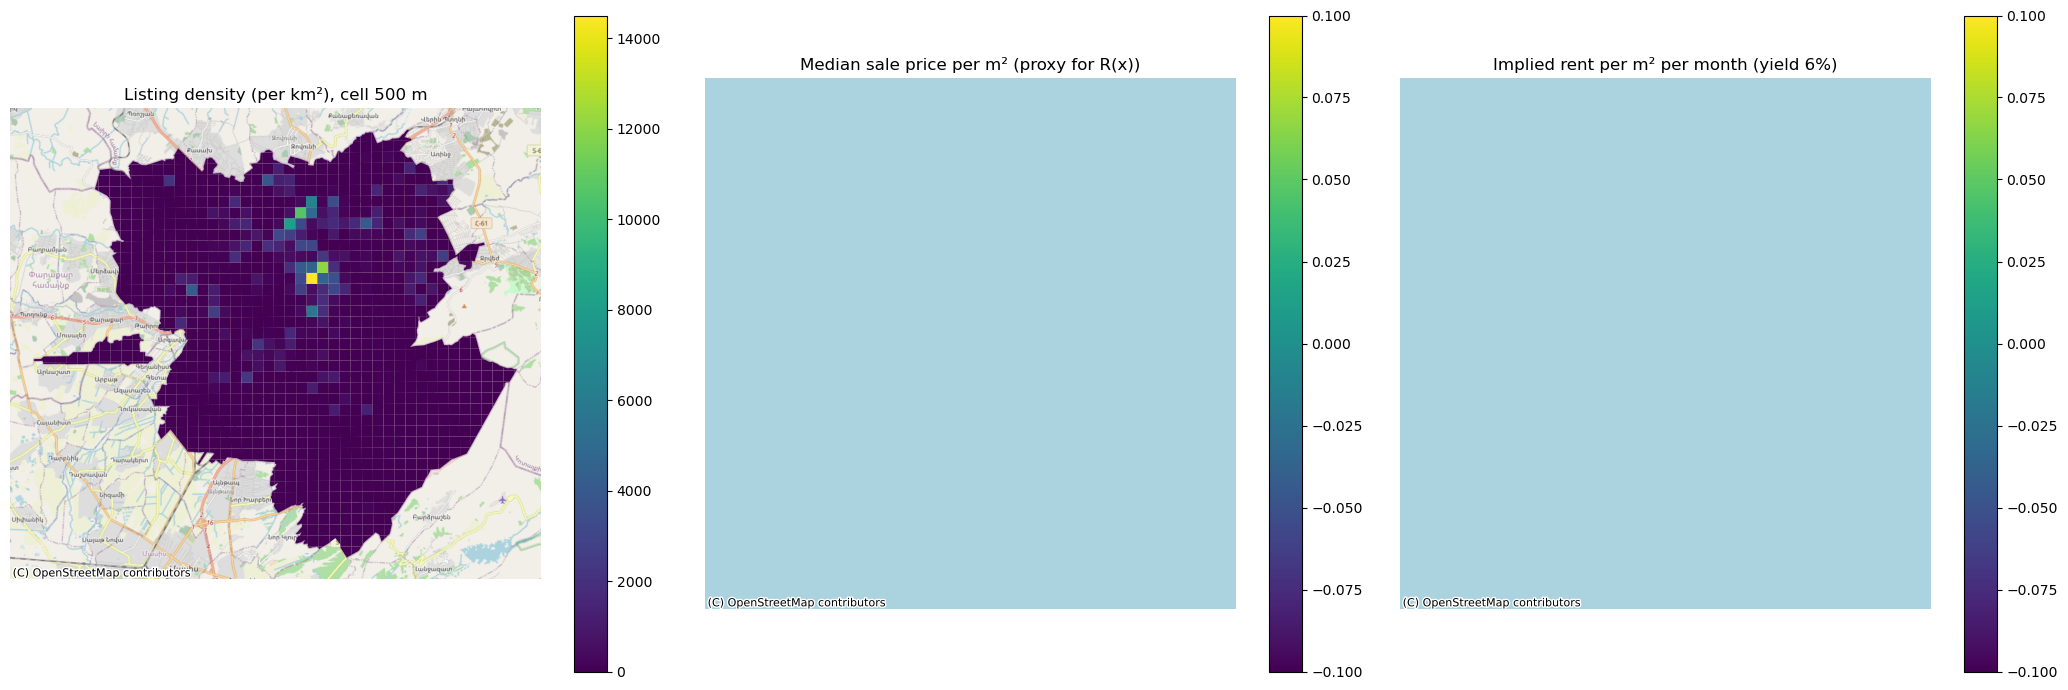

In [22]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.geometry import box
import matplotlib.pyplot as plt
import contextily as ctx

# ----------------------------
# 1) Inputs
# ----------------------------
CSV_PATH = r"data/kaggle_real_estate\apartments_for_sale(with_lat_long).csv"
GRID_CELL_M = 500                 # 250 or 500 are common
GROSS_YIELD_ANNUAL = 0.06         # 6% annual yield used to infer rent
OUT_GPKG = "data/yerevan_rent_proxy/rent_proxy_from_sale_grid.gpkg"

# ----------------------------
# 2) Helpers
# ----------------------------
def first_existing_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def get_yerevan_boundary() -> gpd.GeoDataFrame:
    gdf = ox.geocode_to_gdf("Yerevan, Armenia")
    gdf = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
    if gdf.empty:
        raise RuntimeError("Could not fetch Yerevan polygon.")
    try:
        geom = gdf.geometry.union_all()
    except Exception:
        geom = gdf.geometry.unary_union
    return gpd.GeoDataFrame(geometry=[geom], crs=gdf.crs)

def make_grid(bounds, cell_size_m: int, crs: str):
    minx, miny, maxx, maxy = bounds
    xs = np.arange(minx, maxx + cell_size_m, cell_size_m)
    ys = np.arange(miny, maxy + cell_size_m, cell_size_m)
    cells = []
    for x in xs[:-1]:
        for y in ys[:-1]:
            cells.append(box(x, y, x + cell_size_m, y + cell_size_m))
    grid = gpd.GeoDataFrame({"geometry": cells}, crs=crs)
    grid["cell_id"] = np.arange(len(grid))
    return grid

# ----------------------------
# 3) Load listings and detect columns
# ----------------------------
df = pd.read_csv(CSV_PATH)
print("Columns:", list(df.columns))

lat_col = first_existing_col(df, ["lat", "latitude", "Latitude"])
lon_col = first_existing_col(df, ["lon", "lng", "longitude", "Longitude"])

price_col = first_existing_col(df, ["price", "Price", "price_usd", "priceUSD", "price_amd", "priceAMD"])
area_col  = first_existing_col(df, ["area", "Area", "area_m2", "total_area", "Total area", "sqm", "Square meters"])
currency_col = first_existing_col(df, ["currency", "Currency"])

if not lat_col or not lon_col:
    raise RuntimeError("Could not find lat/lon columns. Check df.columns output above.")

if not price_col:
    raise RuntimeError("Could not find a price column. Check df.columns output above.")

print("Using columns:")
print(" lat:", lat_col)
print(" lon:", lon_col)
print(" price:", price_col)
print(" area:", area_col)
print(" currency:", currency_col)

# Basic cleaning
work = df.dropna(subset=[lat_col, lon_col, price_col]).copy()
work[price_col] = pd.to_numeric(work[price_col], errors="coerce")
work = work.dropna(subset=[price_col])

# If you have currency and mixed units, you can normalize here.
# For now we assume the chosen price column is already consistent (often USD).
if area_col:
    work[area_col] = pd.to_numeric(work[area_col], errors="coerce")
    work.loc[work[area_col] <= 0, area_col] = np.nan
    work["price_per_m2"] = work[price_col] / work[area_col]
else:
    work["price_per_m2"] = np.nan

# ----------------------------
# 4) Convert to GeoDataFrame and clip to Yerevan
# ----------------------------
yerevan = get_yerevan_boundary().to_crs("EPSG:4326")

gdf = gpd.GeoDataFrame(
    work,
    geometry=gpd.points_from_xy(work[lon_col], work[lat_col]),
    crs="EPSG:4326"
)

# Keep only points inside Yerevan polygon
gdf = gdf[gdf.within(yerevan.geometry.iloc[0])].copy()

# Project to meters for grid work
gdf_m = gdf.to_crs("EPSG:32638")
yerevan_m = yerevan.to_crs("EPSG:32638")

print("Listings inside Yerevan:", len(gdf_m))

# ----------------------------
# 5) Build grid and aggregate
# ----------------------------
grid = make_grid(yerevan_m.total_bounds, cell_size_m=GRID_CELL_M, crs=yerevan_m.crs)
grid = gpd.overlay(grid, yerevan_m, how="intersection")
grid["area_km2"] = grid.area / 1_000_000

# Join listings to grid
joined = gpd.sjoin(
    gdf_m[["price_per_m2", price_col, "geometry"]],
    grid[["cell_id", "geometry"]],
    predicate="within",
    how="left"
)

agg = joined.groupby("cell_id").agg(
    listings=("geometry", "size"),
    median_price=("{}".format(price_col), "median"),
    median_price_per_m2=("price_per_m2", "median")
).reset_index()

grid = grid.merge(agg, on="cell_id", how="left")
grid["listings"] = grid["listings"].fillna(0).astype(int)
grid["listings_per_km2"] = grid["listings"] / grid["area_km2"]

# Implied monthly rent per m2 from sale price per m2
grid["implied_rent_per_m2_month"] = (grid["median_price_per_m2"] * GROSS_YIELD_ANNUAL) / 12.0

# ----------------------------
# 6) Save outputs
# ----------------------------
os.makedirs(os.path.dirname(OUT_GPKG), exist_ok=True)
grid.to_file(OUT_GPKG, layer="rent_proxy_grid", driver="GPKG")
print("Saved:", OUT_GPKG)

# ----------------------------
# 7) Plot
# ----------------------------
grid_3857 = grid.to_crs(epsg=3857)

fig, axes = plt.subplots(1, 3, figsize=(21, 7))

ax0 = axes[0]
grid_3857.plot(column="listings_per_km2", ax=ax0, legend=True, linewidth=0)
ctx.add_basemap(ax0, source=ctx.providers.OpenStreetMap.Mapnik)
ax0.set_title(f"Listing density (per km²), cell {GRID_CELL_M} m")
ax0.set_axis_off()

ax1 = axes[1]
grid_3857.plot(column="median_price_per_m2", ax=ax1, legend=True, linewidth=0)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_title("Median sale price per m² (proxy for R(x))")
ax1.set_axis_off()

ax2 = axes[2]
grid_3857.plot(column="implied_rent_per_m2_month", ax=ax2, legend=True, linewidth=0)
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_title(f"Implied rent per m² per month (yield {GROSS_YIELD_ANNUAL:.0%})")
ax2.set_axis_off()

plt.tight_layout()
plt.show()



Columns: ['construction_type', 'new_construction', 'elevator', 'floors_in_the_building', 'floor_area', 'number_of_rooms', 'number_of_bathrooms', 'ceiling_height', 'floor', 'balcony', 'furniture', 'renovation', 'price', 'currency', 'datetime', 'reg_id', 'Latitude', 'Longitude']
Using columns:
 lat: Latitude
 lon: Longitude
 price: price
 area: floor_area
 currency: currency
Filtered currency=USD: 68035 -> 61777 rows
Share of listings with valid area and price_per_m2: 0.9974424138433398
Listings inside Yerevan: 56021
       median_price_per_m2  implied_rent_per_m2_month
count           341.000000                 341.000000
mean           1473.755410                   7.368777
std             593.288925                   2.966445
min              79.365079                   0.396825
25%            1121.495327                   5.607477
50%            1317.647059                   6.588235
75%            1739.130435                   8.695652
max            5161.904762                  25.

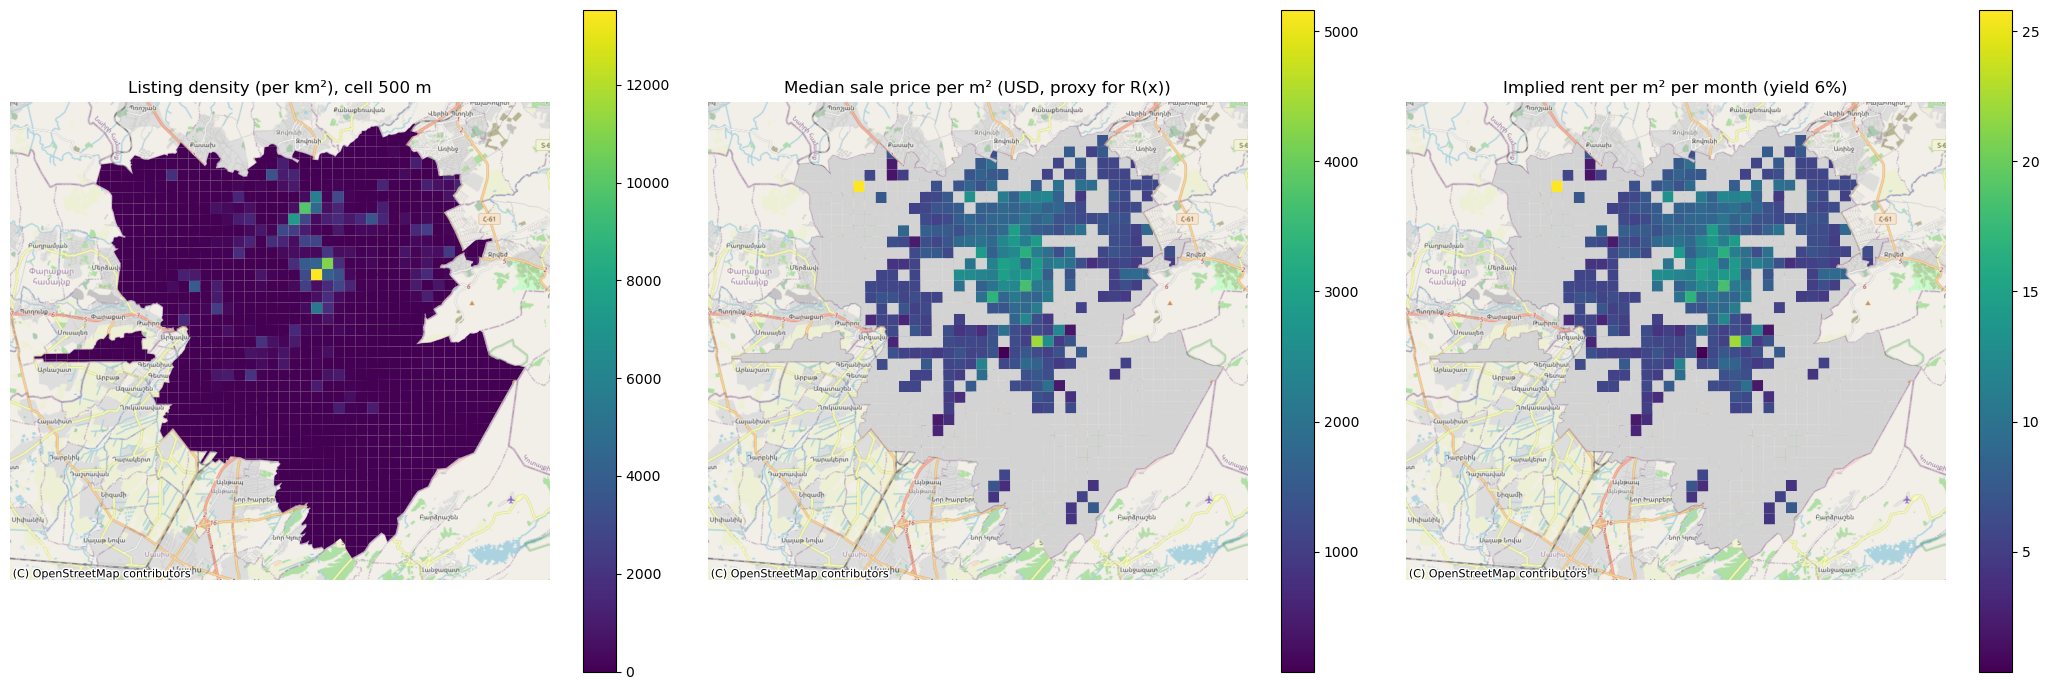

In [24]:
# Full corrected code: build Yerevan "rent proxy" surface from Kaggle sale listings
# Fixes:
# - uses floor_area as area
# - parses floor_area robustly
# - filters/normalizes currency (optional, default: keep USD only)
# - fixes empty right panels
# - forces a valid basemap zoom for contextily
#
# Output:
# - GPKG with grid: data/yerevan_rent_proxy/rent_proxy_from_sale_grid.gpkg
# - 3 maps: listing density, median price per m2, implied rent per m2 per month

import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.geometry import box
import matplotlib.pyplot as plt
import contextily as ctx

# ----------------------------
# CONFIG
# ----------------------------
CSV_PATH = r"data/kaggle_real_estate\apartments_for_sale(with_lat_long).csv"

GRID_CELL_M = 500                  # try 250 if you want more detail
GROSS_YIELD_ANNUAL = 0.06          # used to infer implied rent from price (6%/year)
FILTER_CURRENCY = "USD"            # set to None to keep all, or "USD"/"AMD" etc.

ZOOM_LEVEL = 12                    # basemap zoom (0-19 for OSM Mapnik)
OUT_DIR = "data/yerevan_rent_proxy"
OUT_GPKG = os.path.join(OUT_DIR, "rent_proxy_from_sale_grid.gpkg")
OUT_LAYER = "rent_proxy_grid"

# ----------------------------
# HELPERS
# ----------------------------
def first_existing_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def get_yerevan_boundary() -> gpd.GeoDataFrame:
    gdf = ox.geocode_to_gdf("Yerevan, Armenia")
    gdf = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
    if gdf.empty:
        raise RuntimeError("Could not fetch Yerevan polygon from OSM.")
    try:
        geom = gdf.geometry.union_all()
    except Exception:
        geom = gdf.geometry.unary_union
    return gpd.GeoDataFrame(geometry=[geom], crs=gdf.crs)

def make_grid(bounds, cell_size_m: int, crs: str):
    minx, miny, maxx, maxy = bounds
    xs = np.arange(minx, maxx + cell_size_m, cell_size_m)
    ys = np.arange(miny, maxy + cell_size_m, cell_size_m)

    cells = []
    for x in xs[:-1]:
        for y in ys[:-1]:
            cells.append(box(x, y, x + cell_size_m, y + cell_size_m))

    grid = gpd.GeoDataFrame({"geometry": cells}, crs=crs)
    grid["cell_id"] = np.arange(len(grid))
    return grid

def parse_area(x):
    """Extract first number from strings like '56', '56.5', '56 m2', '56 кв.м'."""
    if pd.isna(x):
        return np.nan
    s = str(x).replace(",", ".")
    m = re.search(r"(\d+(\.\d+)?)", s)
    return float(m.group(1)) if m else np.nan

# ----------------------------
# MAIN
# ----------------------------
def main():
    # Make OSM calls more reliable
    ox.settings.use_cache = True
    ox.settings.log_console = True
    ox.settings.timeout = 180

    os.makedirs(OUT_DIR, exist_ok=True)

    # Load CSV
    df = pd.read_csv(CSV_PATH)
    print("Columns:", list(df.columns))

    lat_col = first_existing_col(df, ["lat", "latitude", "Latitude"])
    lon_col = first_existing_col(df, ["lon", "lng", "longitude", "Longitude"])
    price_col = first_existing_col(df, ["price", "Price", "price_usd", "priceUSD", "price_amd", "priceAMD"])
    currency_col = first_existing_col(df, ["currency", "Currency"])

    # Your dataset uses floor_area (confirmed)
    area_col = "floor_area" if "floor_area" in df.columns else None

    if not lat_col or not lon_col:
        raise RuntimeError("Could not find Latitude/Longitude columns.")
    if not price_col:
        raise RuntimeError("Could not find price column.")
    if not area_col:
        raise RuntimeError("Could not find area column (expected floor_area).")

    print("Using columns:")
    print(" lat:", lat_col)
    print(" lon:", lon_col)
    print(" price:", price_col)
    print(" area:", area_col)
    print(" currency:", currency_col)

    # Clean & filter
    work = df.dropna(subset=[lat_col, lon_col, price_col]).copy()
    work[price_col] = pd.to_numeric(work[price_col], errors="coerce")
    work = work.dropna(subset=[price_col])

    # Optional: filter currency to avoid mixing USD/AMD
    if FILTER_CURRENCY is not None and currency_col is not None:
        work[currency_col] = work[currency_col].astype(str).str.upper().str.strip()
        before = len(work)
        work = work[work[currency_col] == FILTER_CURRENCY].copy()
        print(f"Filtered currency={FILTER_CURRENCY}: {before} -> {len(work)} rows")

    # Parse area and compute price per m2
    work[area_col] = work[area_col].apply(parse_area)
    # sanity bounds, tune if needed
    work.loc[(work[area_col] < 10) | (work[area_col] > 500), area_col] = np.nan

    work["price_per_m2"] = work[price_col] / work[area_col]
    # remove impossible/outlier values
    work.loc[(work["price_per_m2"] <= 0) | (work["price_per_m2"] > 20000), "price_per_m2"] = np.nan

    print("Share of listings with valid area and price_per_m2:",
          float(work["price_per_m2"].notna().mean()))

    # Build Yerevan boundary and clip listings
    yerevan = get_yerevan_boundary().to_crs("EPSG:4326")

    gdf = gpd.GeoDataFrame(
        work,
        geometry=gpd.points_from_xy(work[lon_col], work[lat_col]),
        crs="EPSG:4326"
    )

    # Clip to city polygon
    gdf = gdf[gdf.within(yerevan.geometry.iloc[0])].copy()

    # Project to meters for grid work
    gdf_m = gdf.to_crs("EPSG:32638")
    yerevan_m = yerevan.to_crs("EPSG:32638")

    print("Listings inside Yerevan:", len(gdf_m))

    # Grid over Yerevan
    grid = make_grid(yerevan_m.total_bounds, cell_size_m=GRID_CELL_M, crs=yerevan_m.crs)
    grid = gpd.overlay(grid, yerevan_m, how="intersection")
    grid["area_km2"] = grid.area / 1_000_000

    # Spatial join and aggregate
    joined = gpd.sjoin(
        gdf_m[["price_per_m2", price_col, "geometry"]],
        grid[["cell_id", "geometry"]],
        predicate="within",
        how="left"
    )

    agg = joined.groupby("cell_id").agg(
        listings=("geometry", "size"),
        median_price=(price_col, "median"),
        median_price_per_m2=("price_per_m2", "median"),
    ).reset_index()

    grid = grid.merge(agg, on="cell_id", how="left")
    grid["listings"] = grid["listings"].fillna(0).astype(int)
    grid["listings_per_km2"] = grid["listings"] / grid["area_km2"]

    # Implied monthly rent per m2 (only where price_per_m2 exists)
    grid["implied_rent_per_m2_month"] = (grid["median_price_per_m2"] * GROSS_YIELD_ANNUAL) / 12.0

    print(grid[["median_price_per_m2", "implied_rent_per_m2_month"]].describe())
    print("Cells with price_per_m2 data:", int(grid["median_price_per_m2"].notna().sum()), "out of", len(grid))

    # Save
    grid.to_file(OUT_GPKG, layer=OUT_LAYER, driver="GPKG")
    print("Saved:", OUT_GPKG)

    # Plot
    grid_3857 = grid.to_crs(epsg=3857)

    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    plot_kw = dict(
        legend=True,
        linewidth=0,
        missing_kwds={"color": "lightgrey", "label": "No data"}
    )

    ax0 = axes[0]
    grid_3857.plot(column="listings_per_km2", ax=ax0, **plot_kw)
    ctx.add_basemap(ax0, source=ctx.providers.OpenStreetMap.Mapnik, zoom=ZOOM_LEVEL)
    ax0.set_title(f"Listing density (per km²), cell {GRID_CELL_M} m")
    ax0.set_axis_off()

    ax1 = axes[1]
    grid_3857.plot(column="median_price_per_m2", ax=ax1, **plot_kw)
    ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik, zoom=ZOOM_LEVEL)
    cur = FILTER_CURRENCY if FILTER_CURRENCY else "mixed"
    ax1.set_title(f"Median sale price per m² ({cur}, proxy for R(x))")
    ax1.set_axis_off()

    ax2 = axes[2]
    grid_3857.plot(column="implied_rent_per_m2_month", ax=ax2, **plot_kw)
    ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik, zoom=ZOOM_LEVEL)
    ax2.set_title(f"Implied rent per m² per month (yield {GROSS_YIELD_ANNUAL:.0%})")
    ax2.set_axis_off()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


Saved: data/yerevan_travel/yerevan_travel_times_grid.gpkg


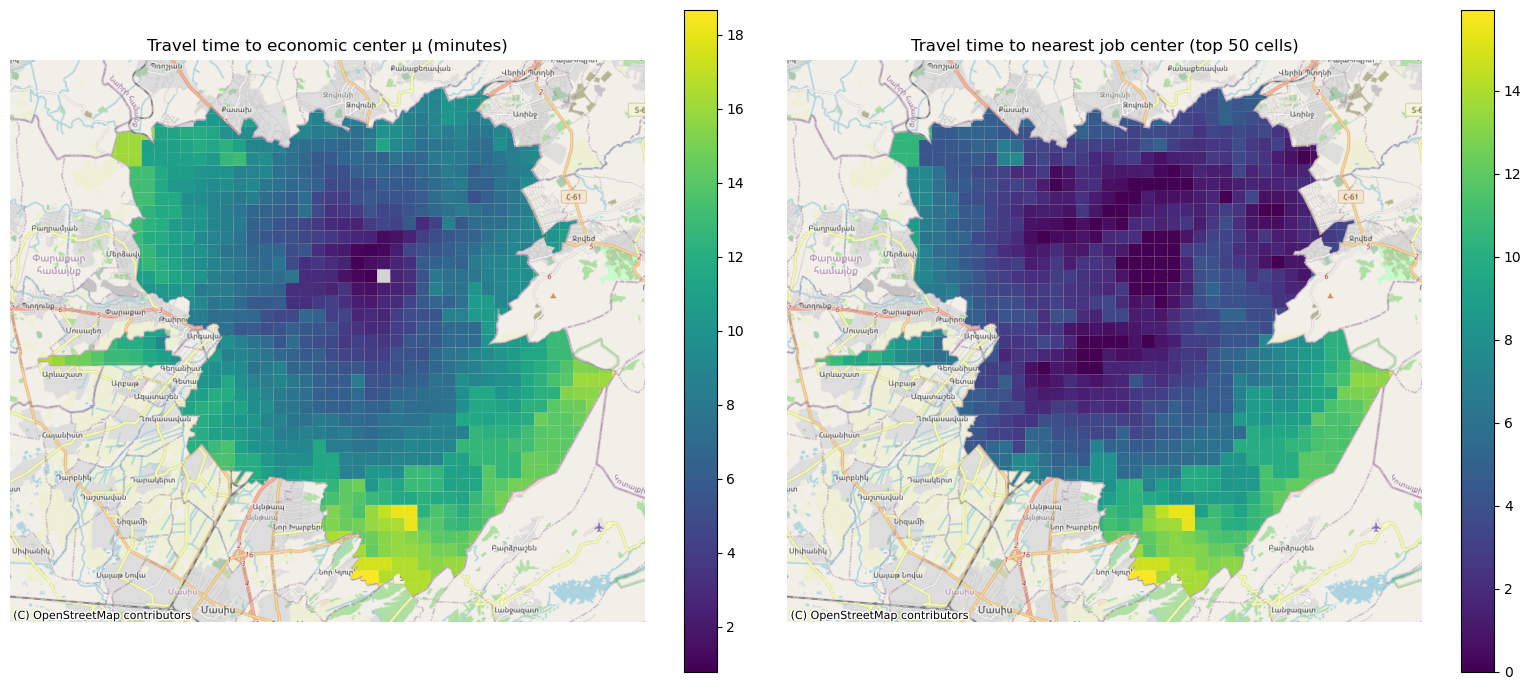

In [28]:
import os
import numpy as np
import geopandas as gpd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import contextily as ctx

# -----------------------------
# Inputs
# -----------------------------
BIZ_GRID_GPKG = "data/yerevan_business_density_grid.gpkg"
BIZ_LAYER = "biz_density_grid"

OUT_GPKG = "data/yerevan_travel/yerevan_travel_times_grid.gpkg"
OUT_LAYER = "travel_times_grid"

NETWORK_TYPE = "drive"        # "drive", "walk", "bike"
TOP_K_JOB_CELLS = 50
ZOOM_LEVEL = 12

VALUE_OF_TIME_AMD_PER_HOUR = 1500.0  # convert minutes -> AMD cost

# -----------------------------
# Geometry validity helpers
# -----------------------------
def make_valid_geom(geom):
    # Shapely 2.x: shapely.make_valid exists, else use buffer(0) fallback
    try:
        import shapely
        if hasattr(shapely, "make_valid"):
            return shapely.make_valid(geom)
    except Exception:
        pass
    # buffer(0) often fixes self-intersections
    try:
        return geom.buffer(0)
    except Exception:
        return geom

# -----------------------------
# Main
# -----------------------------
def main():
    ox.settings.use_cache = True
    ox.settings.log_console = True
    ox.settings.timeout = 180

    # 1) Load grid and ensure CRS
    grid = gpd.read_file(BIZ_GRID_GPKG, layer=BIZ_LAYER)
    if grid.crs is None:
        raise RuntimeError("Grid has no CRS. It should be EPSG:32638 ideally.")

    # Work in meters for centroids and distances
    grid_utm = grid.to_crs("EPSG:32638").copy()
    grid_utm["cx"] = grid_utm.geometry.centroid.x
    grid_utm["cy"] = grid_utm.geometry.centroid.y

    # 2) Build polygon for OSM download in EPSG:4326 (lat/lon)
    grid_ll = grid_utm.to_crs("EPSG:4326")
    try:
        poly_ll = grid_ll.geometry.union_all().convex_hull
    except Exception:
        poly_ll = grid_ll.geometry.unary_union.convex_hull

    poly_ll = make_valid_geom(poly_ll)

    # 3) Download road network
    # truncate_by_edge=True prevents cutting edges too aggressively at polygon boundary
    G = ox.graph_from_polygon(poly_ll, network_type=NETWORK_TYPE, simplify=True, truncate_by_edge=True)
    # Project graph to meters CRS (same as grid)
    G = ox.project_graph(G, to_crs="EPSG:32638")

    # Add speeds and travel time (seconds) on edges
    G = ox.add_edge_speeds(G)
    G = ox.add_edge_travel_times(G)

    # 4) Compute economic center mu from business weights
    if "biz_density_per_km2" in grid_utm.columns:
        w = grid_utm["biz_density_per_km2"].fillna(0).to_numpy()
    elif "biz_count" in grid_utm.columns:
        w = grid_utm["biz_count"].fillna(0).to_numpy()
    else:
        raise RuntimeError("Grid must have biz_density_per_km2 or biz_count column.")

    if w.sum() <= 0:
        raise RuntimeError("Business weights sum to 0. Check your business grid.")

    mu_x = float((grid_utm["cx"].to_numpy() * w).sum() / w.sum())
    mu_y = float((grid_utm["cy"].to_numpy() * w).sum() / w.sum())

    # 5) Snap cell centroids and mu to nearest road nodes
    # Note: Graph is already EPSG:32638, so pass X,Y in meters
    grid_utm["node"] = ox.distance.nearest_nodes(G, X=grid_utm["cx"].to_numpy(), Y=grid_utm["cy"].to_numpy())
    mu_node = ox.distance.nearest_nodes(G, X=mu_x, Y=mu_y)

    # 6) Travel time to mu: single-source shortest paths
    tt_from_mu = nx.single_source_dijkstra_path_length(G, mu_node, weight="travel_time")
    grid_utm["tt_to_mu_min"] = grid_utm["node"].map(lambda n: tt_from_mu.get(n, np.nan) / 60.0)

    # 7) Travel time to nearest job center: pick top K cells by business weight
    if "biz_density_per_km2" in grid_utm.columns:
        top_cells = grid_utm.sort_values("biz_density_per_km2", ascending=False).head(TOP_K_JOB_CELLS)
    else:
        top_cells = grid_utm.sort_values("biz_count", ascending=False).head(TOP_K_JOB_CELLS)

    job_nodes = top_cells["node"].dropna().astype(int).unique().tolist()
    tt_to_nearest_job = nx.multi_source_dijkstra_path_length(G, job_nodes, weight="travel_time")
    grid_utm["tt_to_nearest_job_min"] = grid_utm["node"].map(lambda n: tt_to_nearest_job.get(n, np.nan) / 60.0)

    # 8) Convert minutes to money cost (optional)
    grid_utm["commute_cost_to_mu_amd"] = VALUE_OF_TIME_AMD_PER_HOUR * (grid_utm["tt_to_mu_min"] / 60.0)
    grid_utm["commute_cost_to_nearest_job_amd"] = VALUE_OF_TIME_AMD_PER_HOUR * (grid_utm["tt_to_nearest_job_min"] / 60.0)

    # 9) Save
    os.makedirs(os.path.dirname(OUT_GPKG), exist_ok=True)
    grid_utm.to_file(OUT_GPKG, layer=OUT_LAYER, driver="GPKG")
    print("Saved:", OUT_GPKG)

    # 10) Plot
    g3857 = grid_utm.to_crs(epsg=3857)
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    plot_kw = dict(
        legend=True,
        linewidth=0,
        missing_kwds={"color": "lightgrey", "label": "No route"}
    )

    ax0 = axes[0]
    g3857.plot(column="tt_to_mu_min", ax=ax0, **plot_kw)
    ctx.add_basemap(ax0, source=ctx.providers.OpenStreetMap.Mapnik, zoom=ZOOM_LEVEL)
    ax0.set_title("Travel time to economic center μ (minutes)")
    ax0.set_axis_off()

    ax1 = axes[1]
    g3857.plot(column="tt_to_nearest_job_min", ax=ax1, **plot_kw)
    ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik, zoom=ZOOM_LEVEL)
    ax1.set_title(f"Travel time to nearest job center (top {TOP_K_JOB_CELLS} cells)")
    ax1.set_axis_off()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


Saved: data/yerevan_amenity/yerevan_amenity_grid.gpkg
Heritage points: 778


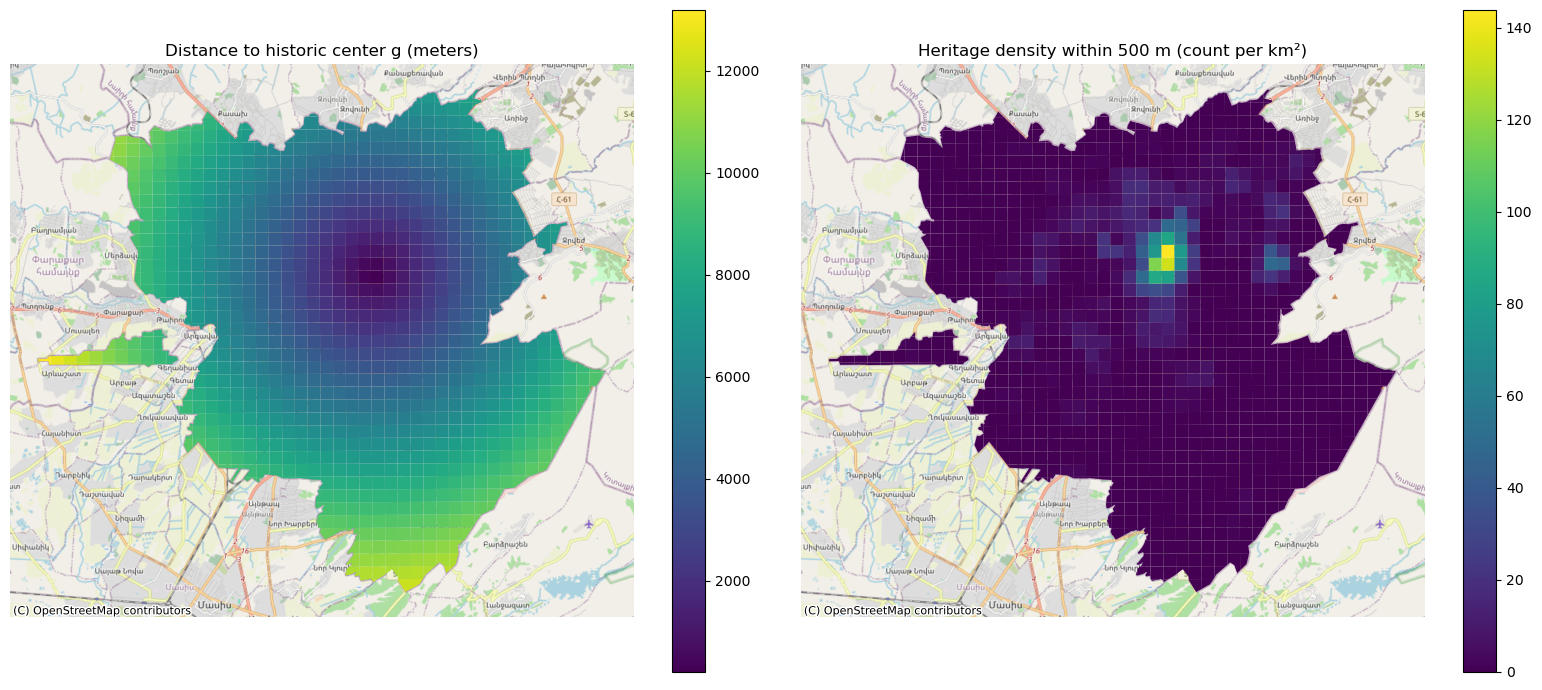

In [30]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

# -----------------------
# Inputs
# -----------------------
GRID_GPKG = "data/yerevan_business_density_grid.gpkg"
GRID_LAYER = "biz_density_grid"

OUT_GPKG = "data/yerevan_amenity/yerevan_amenity_grid.gpkg"
OUT_LAYER = "amenity_grid"

BUFFER_M = 500
ZOOM_LEVEL = 12

# -----------------------
# 1) Load grid (must have geometry + cell_id)
# -----------------------
grid = gpd.read_file(GRID_GPKG, layer=GRID_LAYER)
if grid.crs is None:
    raise RuntimeError("Grid CRS missing. Expected EPSG:32638.")
grid = grid.to_crs("EPSG:32638").copy()

grid["centroid"] = grid.geometry.centroid

# -----------------------
# 2) Choose historic center g
# Option 1: Republic Square
# You can swap to "Erebuni Fortress, Yerevan, Armenia" etc.
# -----------------------
g_place = "Republic Square, Yerevan, Armenia"
g_gdf = ox.geocode_to_gdf(g_place)

# If polygon returned, use centroid
g_geom = g_gdf.geometry.iloc[0]
if g_geom.geom_type in ["Polygon", "MultiPolygon"]:
    g_point = g_geom.centroid
else:
    g_point = g_geom

# Put g into GeoDataFrame and project to meters
g_point_gdf = gpd.GeoDataFrame({"name":[g_place]}, geometry=[g_point], crs=g_gdf.crs).to_crs("EPSG:32638")
g_point_utm = g_point_gdf.geometry.iloc[0]

# -----------------------
# 3) Fetch Yerevan boundary polygon for OSM queries
# -----------------------
yerevan = ox.geocode_to_gdf("Yerevan, Armenia")
yerevan = yerevan[yerevan.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
if yerevan.empty:
    raise RuntimeError("Could not get Yerevan boundary polygon.")
try:
    yerevan_poly = yerevan.geometry.union_all()
except Exception:
    yerevan_poly = yerevan.geometry.unary_union

# -----------------------
# 4) Query OSM for heritage/historic features
# Key:historic and key:heritage are defined in OSM tagging docs :contentReference[oaicite:2]{index=2}
# -----------------------
ox.settings.use_cache = True
ox.settings.log_console = True
ox.settings.timeout = 180

TAGS = {
    "historic": True,                 # any historic=*
    "heritage": True,                 # any heritage=*
    "tourism": ["museum", "attraction"],
    "amenity": ["theatre", "arts_centre"],
    "memorial": True
}

herit_raw = ox.features_from_polygon(yerevan_poly, TAGS)
herit_raw = herit_raw[herit_raw.geometry.notnull()].copy()

# -----------------------
# 5) Convert polygons to points (representative point is inside polygon)
# -----------------------
herit = herit_raw.to_crs("EPSG:32638").copy()
gt = herit.geometry.geom_type

points = herit[gt == "Point"].copy()
polys = herit[gt.isin(["Polygon", "MultiPolygon"])].copy()
polys["geometry"] = polys.geometry.representative_point()

herit_pts = gpd.GeoDataFrame(pd.concat([points, polys], ignore_index=True), crs="EPSG:32638")

# Keep useful columns if present
keep = [c for c in ["name","historic","heritage","tourism","amenity","memorial"] if c in herit_pts.columns]
herit_pts = herit_pts[keep + ["geometry"]].copy()

# -----------------------
# 6) Compute e(x) proxies for each grid cell
#    - distance to g
#    - distance to nearest heritage point
#    - count within BUFFER_M
# -----------------------
grid["dist_to_g_m"] = grid["centroid"].distance(g_point_utm)

# nearest heritage distance (geopandas sjoin_nearest)
cent = gpd.GeoDataFrame(grid[["cell_id"]].copy(), geometry=grid["centroid"], crs=grid.crs)
nearest = gpd.sjoin_nearest(cent, herit_pts[["geometry"]], how="left", distance_col="dist_to_nearest_herit_m")
grid = grid.merge(nearest[["cell_id","dist_to_nearest_herit_m"]], on="cell_id", how="left")

# count heritage points within buffer
buff = cent.copy()
buff["geometry"] = buff.geometry.buffer(BUFFER_M)

join_cnt = gpd.sjoin(herit_pts, buff[["cell_id","geometry"]], predicate="within", how="left")
cnt = join_cnt.groupby("cell_id").size().rename("herit_cnt_500m").reset_index()

grid = grid.merge(cnt, on="cell_id", how="left")
grid["herit_cnt_500m"] = grid["herit_cnt_500m"].fillna(0).astype(int)

# density per km2 inside buffer area
buffer_area_km2 = (np.pi * (BUFFER_M ** 2)) / 1_000_000
grid["herit_density_500m"] = grid["herit_cnt_500m"] / buffer_area_km2

# -----------------------
# 7) Save + plot
# -----------------------
import os
os.makedirs("data/yerevan_amenity", exist_ok=True)
grid.drop(columns=["centroid"], errors="ignore").to_file(OUT_GPKG, layer=OUT_LAYER, driver="GPKG")
print("Saved:", OUT_GPKG)
print("Heritage points:", len(herit_pts))

# Plot 2 panels
g3857 = grid.to_crs(epsg=3857)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

plot_kw = dict(legend=True, linewidth=0, missing_kwds={"color":"lightgrey", "label":"No data"})

ax0 = axes[0]
g3857.plot(column="dist_to_g_m", ax=ax0, **plot_kw)
ctx.add_basemap(ax0, source=ctx.providers.OpenStreetMap.Mapnik, zoom=ZOOM_LEVEL)
ax0.set_title("Distance to historic center g (meters)")
ax0.set_axis_off()

ax1 = axes[1]
g3857.plot(column="herit_density_500m", ax=ax1, **plot_kw)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik, zoom=ZOOM_LEVEL)
ax1.set_title(f"Heritage density within {BUFFER_M} m (count per km²)")
ax1.set_axis_off()

plt.tight_layout()
plt.show()


In [5]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

import statsmodels.api as sm

import rasterio
from rasterstats import zonal_stats

# ---------------------------------
# PATHS (adjust to your files)
# ---------------------------------
BIZ_GPKG = "data/yerevan_business_density_grid.gpkg"
BIZ_LAYER = "biz_density_grid"

PRICE_GPKG = "data/yerevan_rent_proxy/rent_proxy_from_sale_grid.gpkg"
PRICE_LAYER = "rent_proxy_grid"

TRAVEL_GPKG = "data/yerevan_travel/yerevan_travel_times_grid.gpkg"
TRAVEL_LAYER = "travel_times_grid"

AMENITY_GPKG = "data/yerevan_amenity/yerevan_amenity_grid.gpkg"
AMENITY_LAYER = "amenity_grid"

# Your WorldPop clipped raster in UTM 38N
POP_RASTER = "data/yerevan_pop/yerevan_ppp_2020_clipped_utm38n.tif"

OUT_MASTER_GPKG = "data/yerevan_model/master_grid.gpkg"
OUT_MASTER_LAYER = "master"

# ---------------------------------
# HELPERS
# ---------------------------------
def load_grid(path, layer):
    g = gpd.read_file(path, layer=layer)
    if g.crs is None:
        raise RuntimeError(f"{path} has no CRS.")
    return g.to_crs("EPSG:32638")

def attach_raster_sum(base_grid, raster_path, out_col="pop_sum", all_touched=False):
    """Zonal sum of raster values within each polygon cell."""
    with rasterio.open(raster_path) as src:
        nodata = src.nodata

    stats = zonal_stats(
        base_grid,
        raster_path,
        stats=["sum"],
        nodata=nodata,
        all_touched=all_touched
    )
    base_grid[out_col] = [s["sum"] if s["sum"] is not None else 0.0 for s in stats]
    return base_grid

def centroid_nearest_join(base_grid, other_grid, keep_cols, max_dist=None):
    """
    Join attributes from other_grid onto base_grid using nearest centroid match.
    This avoids relying on cell_id being identical across grids.
    """
    base = base_grid.copy()
    other = other_grid.copy()

    base_cent = gpd.GeoDataFrame(
        base[["cell_id"]].copy(),
        geometry=base.geometry.centroid,
        crs=base.crs
    )
    other_cent = gpd.GeoDataFrame(
        other[keep_cols].copy(),
        geometry=other.geometry.centroid,
        crs=other.crs
    )

    joined = gpd.sjoin_nearest(
        base_cent,
        other_cent,
        how="left",
        max_distance=max_dist,
        distance_col="_join_dist"
    )

    cols_to_merge = ["cell_id"] + keep_cols
    base = base.merge(joined[cols_to_merge], on="cell_id", how="left")
    return base

def solve_equilibrium(df, t, e, phi, v=0.0, firm_share=0.30, max_iter=50, tol=1e-6):
    """
    Discrete bid-rent allocation equilibrium on a grid.

    Rc_i ~ - t * travel_time_to_mu(i) - e * dist_to_g(i)
    Rf_i ~ - phi * dist_to_mu(i) - v * dist_to_g(i)

    Allocate top firm_share cells by (Rf - Rc) to firms, update mu as firms centroid.
    """
    g = df.copy()
    g = g.to_crs("EPSG:32638")

    cent = g.geometry.centroid
    g["x"] = cent.x
    g["y"] = cent.y

    # init mu from observed business weights if available
    if "biz_density_per_km2" in g.columns and g["biz_density_per_km2"].notna().any():
        w = g["biz_density_per_km2"].fillna(0).to_numpy()
        if w.sum() > 0:
            mu = np.array([(g["x"]*w).sum()/w.sum(), (g["y"]*w).sum()/w.sum()])
        else:
            mu = np.array([g["x"].mean(), g["y"].mean()])
    elif "biz_count" in g.columns and g["biz_count"].notna().any():
        w = g["biz_count"].fillna(0).to_numpy()
        if w.sum() > 0:
            mu = np.array([(g["x"]*w).sum()/w.sum(), (g["y"]*w).sum()/w.sum()])
        else:
            mu = np.array([g["x"].mean(), g["y"].mean()])
    else:
        mu = np.array([g["x"].mean(), g["y"].mean()])

    n_firms = int(np.round(firm_share * len(g)))

    for _ in range(max_iter):
        g["dist_to_mu_m"] = np.sqrt((g["x"]-mu[0])**2 + (g["y"]-mu[1])**2)

        Rc = -t * g["tt_to_mu_min"] - e * g["dist_to_g_m"]
        Rf = -phi * g["dist_to_mu_m"] - v * g["dist_to_g_m"]
        g["delta"] = (Rf - Rc)

        g = g.sort_values("delta", ascending=False).copy()
        g["is_firm"] = 0
        g.iloc[:n_firms, g.columns.get_loc("is_firm")] = 1

        firms = g[g["is_firm"] == 1]
        mu_new = np.array([firms["x"].mean(), firms["y"].mean()])

        if np.linalg.norm(mu_new - mu) < tol:
            mu = mu_new
            break
        mu = mu_new

    return g, mu

# ---------------------------------
# 1) LOAD BASE GRID (business)
# ---------------------------------
base = load_grid(BIZ_GPKG, BIZ_LAYER)

# Make sure base has cell_id
if "cell_id" not in base.columns:
    base["cell_id"] = np.arange(len(base))

# ---------------------------------
# 2) ADD POPULATION FROM RASTER (N(x))
# ---------------------------------
base["cell_area_km2"] = base.area / 1_000_000
base = attach_raster_sum(base, POP_RASTER, out_col="pop_sum", all_touched=False)
base["pop_density_per_km2"] = base["pop_sum"] / base["cell_area_km2"]

# ---------------------------------
# 3) JOIN PRICE, TRAVEL, AMENITY GRIDS
# ---------------------------------
price = load_grid(PRICE_GPKG, PRICE_LAYER)
travel = load_grid(TRAVEL_GPKG, TRAVEL_LAYER)
amen = load_grid(AMENITY_GPKG, AMENITY_LAYER)

# Keep only needed cols
price_cols = [c for c in ["median_price_per_m2", "implied_rent_per_m2_month"] if c in price.columns]
travel_cols = [c for c in ["tt_to_mu_min", "tt_to_nearest_job_min"] if c in travel.columns]
amen_cols = [c for c in ["dist_to_g_m", "herit_density_500m", "herit_cnt_500m", "dist_to_nearest_herit_m"] if c in amen.columns]

base = centroid_nearest_join(base, price, price_cols, max_dist=5)   # meters
base = centroid_nearest_join(base, travel, travel_cols, max_dist=5)
base = centroid_nearest_join(base, amen, amen_cols, max_dist=5)

# ---------------------------------
# 4) BUILD MASTER TABLE
# Choose R(x) proxy: sale price per m2 is most stable here
# ---------------------------------
base["R"] = base["median_price_per_m2"]

# Clean: keep cells with required variables
need = ["R", "tt_to_mu_min", "dist_to_g_m"]
master = base.dropna(subset=need).copy()
master = master.replace([np.inf, -np.inf], np.nan)

print("Master cells:", len(master), "of", len(base))

# ---------------------------------
# 5) ESTIMATE reduced-form t and e via price regression
# log(R) = a + b_tau * tt_to_mu + b_g * dist_to_g + b_H * heritage_density
# ---------------------------------
master["logR"] = np.log(master["R"])

X = master[["tt_to_mu_min", "dist_to_g_m"]].copy()
if "herit_density_500m" in master.columns:
    X["herit_density_500m"] = master["herit_density_500m"].fillna(0)

X = sm.add_constant(X)
y = master["logR"]

ols = sm.OLS(y, X).fit(cov_type="HC1")
print(ols.summary())

b_tau = float(ols.params["tt_to_mu_min"])
b_g = float(ols.params["dist_to_g_m"])

# Positive weights (up to scale) for the bid-rent solver
t_hat = max(1e-9, -b_tau)
e_hat = max(1e-12, -b_g)

print("t_hat (per minute, log-price scale):", t_hat)
print("e_hat (per meter, log-price scale):", e_hat)

# ---------------------------------
# 6) SOLVE EQUILIBRIUM + COUNTERFACTUALS
# ---------------------------------
# phi is a tuning parameter: stronger phi means firms cluster more tightly
phi0 = 0.001  # per meter, tune later

# Firm land share: start with 30% and later calibrate from observed business footprint
firm_share = 0.30

baseline_alloc, mu0 = solve_equilibrium(master, t_hat, e_hat, phi0, v=0.0, firm_share=firm_share)
alloc_tlow, mu_tlow = solve_equilibrium(master, t_hat*0.8, e_hat, phi0, v=0.0, firm_share=firm_share)
alloc_ehigh, mu_ehigh = solve_equilibrium(master, t_hat, e_hat*1.2, phi0, v=0.0, firm_share=firm_share)

def dist(a, b):
    return float(np.linalg.norm(np.array(a) - np.array(b)))

print("mu0:", mu0)
print("mu_tlow:", mu_tlow, "shift meters:", dist(mu_tlow, mu0))
print("mu_ehigh:", mu_ehigh, "shift meters:", dist(mu_ehigh, mu0))

# ---------------------------------
# 7) SAVE MASTER GRID
# ---------------------------------
os.makedirs("data/yerevan_model", exist_ok=True)
master.to_file(OUT_MASTER_GPKG, layer=OUT_MASTER_LAYER, driver="GPKG")
print("Saved master grid:", OUT_MASTER_GPKG)

baseline_alloc.to_file("data/yerevan_model/allocation_baseline.gpkg", layer="baseline", driver="GPKG")
alloc_tlow.to_file("data/yerevan_model/allocation_tlow.gpkg", layer="tlow", driver="GPKG")
alloc_ehigh.to_file("data/yerevan_model/allocation_ehigh.gpkg", layer="ehigh", driver="GPKG")
print("Saved allocations to data/yerevan_model/")


Master cells: 340 of 1036
                            OLS Regression Results                            
Dep. Variable:                   logR   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     46.18
Date:                Sun, 25 Jan 2026   Prob (F-statistic):           5.16e-25
Time:                        18:50:02   Log-Likelihood:                -112.73
No. Observations:                 340   AIC:                             233.5
Df Residuals:                     336   BIC:                             248.8
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const     

In [7]:
# Estimate the 2D (grid) version of Goncharov-style allocation with an endogenous economic center μ
#
# What this script does:
# 1) Builds one master grid (base = your business grid geometry)
# 2) Adds:
#    - N(x): population density from WorldPop raster (zonal sum)
#    - M(x): business density from your OSM business grid
#    - R(x): rent proxy from your Kaggle sale grid (median price per m2 or implied rent)
#    - e(x) proxies: distance to g and heritage density (from your amenity grid)
#    - commuting: travel times to μ (from your travel-times grid) if available
# 3) Estimates an iterative logit land-use model where μ is updated from predicted business shares:
#      s_i = sigmoid(β0 + β1 dist(i,μ) + β2 tt(i,μ) + β3 dist(i,g) + β4 heritage + controls)
#      μ = Σ s_i x_i / Σ s_i
#
# Requirements:
#   pip install geopandas osmnx rasterio rasterstats shapely pandas numpy statsmodels scikit-learn
#
# Notes:
# - This is an operational 2D reformulation for real data and counterfactuals.
# - It does not reproduce every closed-form piece of the 1D thesis, but it matches the core mechanism:
#   business wants to be near μ (spillovers), residents want low commute to μ and proximity to g.

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import rasterio
from rasterstats import zonal_stats
from shapely.geometry import Point
import statsmodels.api as sm

# -----------------------------
# CONFIG: paths to your artifacts
# -----------------------------
# Base grid (must have biz_density_per_km2 or biz_count)
BIZ_GRID_GPKG = r"data/yerevan_business_density_grid.gpkg"
BIZ_LAYER = "biz_density_grid"

# WorldPop clipped raster in EPSG:32638 (you already created it earlier)
POP_RASTER = r"data/yerevan_pop/yerevan_ppp_2020_clipped_utm38n.tif"

# Rent proxy grid from Kaggle sale listings (output of your corrected rent script)
RENT_GRID_GPKG = r"data/yerevan_rent_proxy/rent_proxy_from_sale_grid.gpkg"
RENT_LAYER = "rent_proxy_grid"

# Amenity grid from OSM heritage script
AMENITY_GPKG = r"data/yerevan_amenity/yerevan_amenity_grid.gpkg"
AMENITY_LAYER = "amenity_grid"

# Travel time grid from the corrected OSMnx travel-time script
TRAVEL_GPKG = r"data/yerevan_travel/yerevan_travel_times_grid.gpkg"
TRAVEL_LAYER = "travel_times_grid"

# Outputs
OUT_DIR = r"data/yerevan_model"
OUT_MASTER_GPKG = os.path.join(OUT_DIR, "yerevan_master_grid.gpkg")
OUT_MASTER_LAYER = "master_grid"

# Model choices
HISTORIC_CENTER_PLACE = "Republic Square, Yerevan, Armenia"   # your g
BUSINESS_THRESHOLD = 0.0  # y_i = 1 if biz_density_per_km2 > threshold (0 uses any business presence)
MAX_ITERS = 20
TOL_M = 50.0              # μ convergence tolerance in meters

# Which rent variable to use
# If your rent grid has these columns, pick one:
# - median_price_per_m2
# - implied_rent_per_m2_month
RENT_COL_CANDIDATES = ["implied_rent_per_m2_month", "median_price_per_m2"]

# Feature standardization
STANDARDIZE = True


# -----------------------------
# Helpers
# -----------------------------
def ensure_crs(gdf: gpd.GeoDataFrame, epsg: int = 32638) -> gpd.GeoDataFrame:
    if gdf.crs is None:
        raise RuntimeError("GeoDataFrame CRS is missing. Save layers with CRS info.")
    return gdf.to_crs(epsg=epsg)

def centroid_points(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    out = gdf.copy()
    out["geometry"] = out.geometry.centroid
    return out

def pick_first_existing(df_cols, candidates):
    for c in candidates:
        if c in df_cols:
            return c
    return None

def add_population_from_raster(base_grid_utm: gpd.GeoDataFrame, raster_path: str) -> gpd.GeoDataFrame:
    with rasterio.open(raster_path) as src:
        nodata = src.nodata
    zs = zonal_stats(base_grid_utm, raster_path, stats=["sum"], nodata=nodata, all_touched=False)
    pop_sum = np.array([z["sum"] if z["sum"] is not None else 0.0 for z in zs], dtype=float)

    out = base_grid_utm.copy()
    out["pop_sum"] = pop_sum
    out["area_km2"] = out.geometry.area / 1_000_000.0
    out["pop_density_per_km2"] = out["pop_sum"] / out["area_km2"].replace(0, np.nan)
    return out

def transfer_columns_by_nearest_centroid(base_grid_utm: gpd.GeoDataFrame,
                                         other_grid_utm: gpd.GeoDataFrame,
                                         cols: list,
                                         prefix: str = "") -> gpd.GeoDataFrame:
    """
    Spatially transfer columns from other_grid to base_grid using nearest centroid.
    Works even if cell_id does not match across files.
    """
    base_cent = centroid_points(base_grid_utm[["geometry"]].copy())
    other_cent = centroid_points(other_grid_utm[cols + ["geometry"]].copy())

    joined = gpd.sjoin_nearest(base_cent, other_cent, how="left", distance_col="_dist_join")
    out = base_grid_utm.copy()
    for c in cols:
        out[prefix + c] = joined[c].to_numpy()
    return out

def get_g_point_utm(place: str, epsg: int = 32638) -> Point:
    gdf = ox.geocode_to_gdf(place)
    geom = gdf.geometry.iloc[0]
    if geom.geom_type in ["Polygon", "MultiPolygon"]:
        geom = geom.centroid
    gpt = gpd.GeoDataFrame({"name":[place]}, geometry=[geom], crs=gdf.crs).to_crs(epsg=epsg)
    return gpt.geometry.iloc[0]

def standardize_cols(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        v = out[c].astype(float)
        m = np.nanmean(v)
        s = np.nanstd(v)
        if s == 0 or np.isnan(s):
            out[c] = v
        else:
            out[c] = (v - m) / s
    return out


# -----------------------------
# Step 1: Build master dataset on one grid
# -----------------------------
os.makedirs(OUT_DIR, exist_ok=True)

# Load base business grid
base = gpd.read_file(BIZ_GRID_GPKG, layer=BIZ_LAYER)
base = ensure_crs(base, 32638)

# Business variables
if "biz_density_per_km2" not in base.columns and "biz_count" not in base.columns:
    raise RuntimeError("Business grid must contain biz_density_per_km2 or biz_count.")

# Add centroids (x,y)
base["cx"] = base.geometry.centroid.x
base["cy"] = base.geometry.centroid.y

# Add population from raster
base = add_population_from_raster(base, POP_RASTER)

# Load rent grid and transfer rent columns
rent_g = ensure_crs(gpd.read_file(RENT_GRID_GPKG, layer=RENT_LAYER), 32638)
rent_col = pick_first_existing(rent_g.columns, RENT_COL_CANDIDATES)
if rent_col is None:
    raise RuntimeError(f"Could not find any rent column in rent grid. Looked for: {RENT_COL_CANDIDATES}")

base = transfer_columns_by_nearest_centroid(base, rent_g, cols=[rent_col], prefix="rent_")

# Load amenity grid and transfer amenity columns (if exist)
amen_g = ensure_crs(gpd.read_file(AMENITY_GPKG, layer=AMENITY_LAYER), 32638)
amen_cols = [c for c in ["dist_to_g_m", "dist_to_nearest_herit_m", "herit_cnt_500m", "herit_density_500m"] if c in amen_g.columns]
if len(amen_cols) == 0:
    raise RuntimeError("Amenity grid does not have expected columns. Re-run amenity builder script.")
base = transfer_columns_by_nearest_centroid(base, amen_g, cols=amen_cols, prefix="amen_")

# Load travel grid and transfer travel columns (if file exists)
if os.path.exists(TRAVEL_GPKG):
    trav_g = ensure_crs(gpd.read_file(TRAVEL_GPKG, layer=TRAVEL_LAYER), 32638)
    trav_cols = [c for c in ["tt_to_mu_min", "tt_to_nearest_job_min"] if c in trav_g.columns]
    if len(trav_cols) > 0:
        base = transfer_columns_by_nearest_centroid(base, trav_g, cols=trav_cols, prefix="trav_")

# Save master grid
base.to_file(OUT_MASTER_GPKG, layer=OUT_MASTER_LAYER, driver="GPKG")
print("Saved master grid:", OUT_MASTER_GPKG)
print("Rent column used:", rent_col)

# -----------------------------
# Step 2: Build the estimation table
# -----------------------------
df = base.copy()

# Define business indicator y_i for the logit
if "biz_density_per_km2" in df.columns:
    df["y_business"] = (df["biz_density_per_km2"].fillna(0) > BUSINESS_THRESHOLD).astype(int)
    biz_w = df["biz_density_per_km2"].fillna(0).to_numpy()
else:
    df["y_business"] = (df["biz_count"].fillna(0) > BUSINESS_THRESHOLD).astype(int)
    biz_w = df["biz_count"].fillna(0).to_numpy()

# Historic center point g (for backup distance if amenity dist is missing)
g_point = get_g_point_utm(HISTORIC_CENTER_PLACE, epsg=32638)

# Ensure we have a distance-to-g variable
if "amen_dist_to_g_m" not in df.columns:
    df["amen_dist_to_g_m"] = df.geometry.centroid.distance(g_point)

# Choose commuting time to μ if available; else use Euclidean distance to μ as fallback
has_tt = "trav_tt_to_mu_min" in df.columns and df["trav_tt_to_mu_min"].notna().sum() > 0

# Choose a heritage proxy
herit_proxy = "amen_herit_density_500m" if "amen_herit_density_500m" in df.columns else None

# Choose rent variable
rent_var = "rent_" + rent_col

# Drop obviously bad rows
df[rent_var] = pd.to_numeric(df[rent_var], errors="coerce")
df["pop_density_per_km2"] = pd.to_numeric(df["pop_density_per_km2"], errors="coerce")

# -----------------------------
# Step 3: Iterative estimation with endogenous μ
# -----------------------------
# Initial μ from observed business weights
w_sum = biz_w.sum()
if w_sum <= 0:
    raise RuntimeError("Business weights sum to zero. Check biz grid values.")
mu_x = float((df["cx"].to_numpy() * biz_w).sum() / w_sum)
mu_y = float((df["cy"].to_numpy() * biz_w).sum() / w_sum)

def compute_dist_mu(cur_df: gpd.GeoDataFrame, mx: float, my: float) -> np.ndarray:
    dx = cur_df["cx"].to_numpy() - mx
    dy = cur_df["cy"].to_numpy() - my
    return np.sqrt(dx*dx + dy*dy)

results_by_iter = []

for it in range(MAX_ITERS):
    # Distance to current μ
    df["dist_to_mu_m"] = compute_dist_mu(df, mu_x, mu_y)

    # Build feature matrix
    # Core features:
    features = ["dist_to_mu_m", "amen_dist_to_g_m"]

    # commuting time to μ if available, else approximate by dist_to_mu_m
    if has_tt:
        features.append("trav_tt_to_mu_min")
    else:
        # If no travel times, you can still estimate with distance to μ and treat t as slope on distance
        pass

    # heritage intensity (optional)
    if herit_proxy is not None:
        features.append(herit_proxy)

    # control: population density (optional but often helpful)
    features.append("pop_density_per_km2")

    # Clean NA rows for estimation
    est = df[["y_business"] + features + ["cx", "cy"]].copy()
    est = est.replace([np.inf, -np.inf], np.nan).dropna()

    # Optionally standardize numeric features for stability
    if STANDARDIZE:
        est = standardize_cols(est, features)

    # Fit logit
    X = sm.add_constant(est[features], has_constant="add")
    y = est["y_business"].astype(int)
    logit = sm.Logit(y, X).fit(disp=False)

    # Predict business share on all rows (including those dropped)
    full = df[features].copy()
    full = full.replace([np.inf, -np.inf], np.nan)

    if STANDARDIZE:
        # Standardize using est means/stds (recompute from est to match)
        for c in features:
            m = est[c].mean()
            s = est[c].std()
            if s == 0 or np.isnan(s):
                full[c] = full[c]
            else:
                full[c] = (full[c] - m) / s

    X_full = sm.add_constant(full, has_constant="add")
    pred = logit.predict(X_full)

    # Update μ from predicted shares
    pred = pred.to_numpy()
    valid = np.isfinite(pred)
    pred_valid = pred[valid]
    cx_valid = df.loc[valid, "cx"].to_numpy()
    cy_valid = df.loc[valid, "cy"].to_numpy()

    denom = pred_valid.sum()
    if denom <= 1e-9:
        raise RuntimeError("Predicted business shares sum to ~0. Model is unstable. Try different threshold or features.")

    mu_x_new = float((cx_valid * pred_valid).sum() / denom)
    mu_y_new = float((cy_valid * pred_valid).sum() / denom)

    shift = float(np.sqrt((mu_x_new - mu_x)**2 + (mu_y_new - mu_y)**2))

    results_by_iter.append({
        "iter": it,
        "mu_x": mu_x,
        "mu_y": mu_y,
        "mu_x_new": mu_x_new,
        "mu_y_new": mu_y_new,
        "shift_m": shift,
        "n_obs": int(len(est)),
        "llf": float(logit.llf)
    })

    print(f"iter {it}: shift {shift:.1f} m, n={len(est)}, llf={logit.llf:.2f}")

    mu_x, mu_y = mu_x_new, mu_y_new

    if shift < TOL_M:
        print("Converged.")
        break

# Attach final predicted shares and final μ to df
df["s_business_hat"] = logit.predict(X_full)
df["mu_x_hat"] = mu_x
df["mu_y_hat"] = mu_y

# Compute separation from g
df["g_x"] = g_point.x
df["g_y"] = g_point.y
center_sep_m = float(np.sqrt((mu_x - g_point.x)**2 + (mu_y - g_point.y)**2))
print("Final center separation |μ - g| (m):", center_sep_m)

# Save estimation output grid
out_path = os.path.join(OUT_DIR, "yerevan_estimated_allocation.gpkg")
df.to_file(out_path, layer="estimated_grid", driver="GPKG")
print("Saved estimated grid:", out_path)

# Save iteration diagnostics
diag = pd.DataFrame(results_by_iter)
diag_path = os.path.join(OUT_DIR, "mu_iterations.csv")
diag.to_csv(diag_path, index=False)
print("Saved μ iteration log:", diag_path)

# Print final model summary
print("\nFinal logit summary:")
print(logit.summary())

# -----------------------------
# Optional: estimate historic amenity gradient from rent (hedonic style)
# -----------------------------
# Example: log(rent proxy) on dist_to_g and commuting (tt_to_mu or dist_to_mu) + heritage + pop density
try:
    reg = base.copy()
    reg[rent_var] = pd.to_numeric(reg[rent_var], errors="coerce")
    reg = reg.replace([np.inf, -np.inf], np.nan).dropna(subset=[rent_var, "amen_dist_to_g_m", "pop_density_per_km2"])

    reg["log_rent"] = np.log(reg[rent_var].clip(lower=1e-9))
    reg["dist_g_km"] = reg["amen_dist_to_g_m"] / 1000.0
    reg["dist_mu_km"] = np.sqrt((reg["cx"] - mu_x)**2 + (reg["cy"] - mu_y)**2) / 1000.0

    hed_feats = ["dist_g_km", "dist_mu_km", "pop_density_per_km2"]
    if "amen_herit_density_500m" in reg.columns:
        hed_feats.append("amen_herit_density_500m")
    if has_tt and "trav_tt_to_mu_min" in reg.columns:
        hed_feats.append("trav_tt_to_mu_min")

    H = sm.add_constant(reg[hed_feats], has_constant="add")
    hed = sm.OLS(reg["log_rent"], H).fit(cov_type="HC1")

    print("\nHedonic regression (log rent proxy):")
    print(hed.summary())
except Exception as ex:
    print("\nHedonic regression skipped due to error:", ex)


Saved master grid: data/yerevan_model\yerevan_master_grid.gpkg
Rent column used: implied_rent_per_m2_month
iter 0: shift 1470.1 m, n=1033, llf=-435.97
iter 1: shift 1321.8 m, n=1033, llf=-433.30
iter 2: shift 80.6 m, n=1033, llf=-432.62
iter 3: shift 0.2 m, n=1033, llf=-432.58
Converged.
Final center separation |μ - g| (m): 1913.4160440871096
Saved estimated grid: data/yerevan_model\yerevan_estimated_allocation.gpkg
Saved μ iteration log: data/yerevan_model\mu_iterations.csv

Final logit summary:
                           Logit Regression Results                           
Dep. Variable:             y_business   No. Observations:                 1033
Model:                          Logit   Df Residuals:                     1027
Method:                           MLE   Df Model:                            5
Date:                Sun, 25 Jan 2026   Pseudo R-squ.:                  0.3958
Time:                        19:18:43   Log-Likelihood:                -432.58
converged:              

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [8]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# est is your estimation frame you used (y_business + features), or rebuild it:
# est = df[["y_business", ...]].replace([np.inf,-np.inf], np.nan).dropna()

def fit_logit(est, features):
    X = sm.add_constant(est[features], has_constant="add")
    y = est["y_business"].astype(int)
    return sm.Logit(y, X).fit(disp=False)

# Model A: keep travel time, drop euclidean distance
feat_A = ["trav_tt_to_mu_min", "amen_dist_to_g_m", "amen_herit_density_500m", "pop_density_per_km2"]
mA = fit_logit(est, feat_A)
print(mA.summary())

# Model B: keep euclidean distance, drop travel time
feat_B = ["dist_to_mu_m", "amen_dist_to_g_m", "amen_herit_density_500m", "pop_density_per_km2"]
mB = fit_logit(est, feat_B)
print(mB.summary())


                           Logit Regression Results                           
Dep. Variable:             y_business   No. Observations:                 1033
Model:                          Logit   Df Residuals:                     1028
Method:                           MLE   Df Model:                            4
Date:                Sun, 25 Jan 2026   Pseudo R-squ.:                  0.3903
Time:                        21:29:52   Log-Likelihood:                -436.51
converged:                       True   LL-Null:                       -716.00
Covariance Type:            nonrobust   LLR p-value:                1.169e-119
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.6690      0.207      3.233      0.001       0.263       1.075
trav_tt_to_mu_min          -1.3823      0.260     -5.325      0.000      -1.891      -0.873


In [9]:
import numpy as np
import statsmodels.api as sm

reg = base.copy()

y = reg[rent_var].replace([np.inf, -np.inf], np.nan)
reg = reg.loc[y.notna() & (y > 0)].copy()
reg["log_rent"] = np.log(reg[rent_var].clip(lower=1e-6))

reg["dist_g_km"] = reg["amen_dist_to_g_m"] / 1000.0
reg["dist_mu_km"] = np.sqrt((reg["cx"] - mu_x)**2 + (reg["cy"] - mu_y)**2) / 1000.0

X_cols = ["dist_g_km", "dist_mu_km", "pop_density_per_km2"]
if "amen_herit_density_500m" in reg.columns:
    X_cols.append("amen_herit_density_500m")
if "trav_tt_to_mu_min" in reg.columns:
    X_cols.append("trav_tt_to_mu_min")

X = reg[X_cols].replace([np.inf, -np.inf], np.nan).dropna()
reg = reg.loc[X.index].copy()

# winsorize pop density a bit (optional)
p1, p99 = reg["pop_density_per_km2"].quantile([0.01, 0.99])
reg["pop_density_per_km2"] = reg["pop_density_per_km2"].clip(p1, p99)
X["pop_density_per_km2"] = reg["pop_density_per_km2"]

X = sm.add_constant(X, has_constant="add")
hed = sm.OLS(reg["log_rent"], X).fit(cov_type="HC1")
print(hed.summary())


                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     39.22
Date:                Sun, 25 Jan 2026   Prob (F-statistic):           1.19e-31
Time:                        21:55:17   Log-Likelihood:                -96.028
No. Observations:                 340   AIC:                             204.1
Df Residuals:                     334   BIC:                             227.0
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Model A fit on n = 1033
                           Logit Regression Results                           
Dep. Variable:             y_business   No. Observations:                 1033
Model:                          Logit   Df Residuals:                     1028
Method:                           MLE   Df Model:                            4
Date:                Sun, 25 Jan 2026   Pseudo R-squ.:                  0.3903
Time:                        22:04:44   Log-Likelihood:                -436.51
converged:                       True   LL-Null:                       -716.00
Covariance Type:            nonrobust   LLR p-value:                1.169e-119
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.6690      0.207      3.233      0.001       0.263       1.075
trav_tt_to_mu_min          -1.3829      0.260     -5.325      0.000 

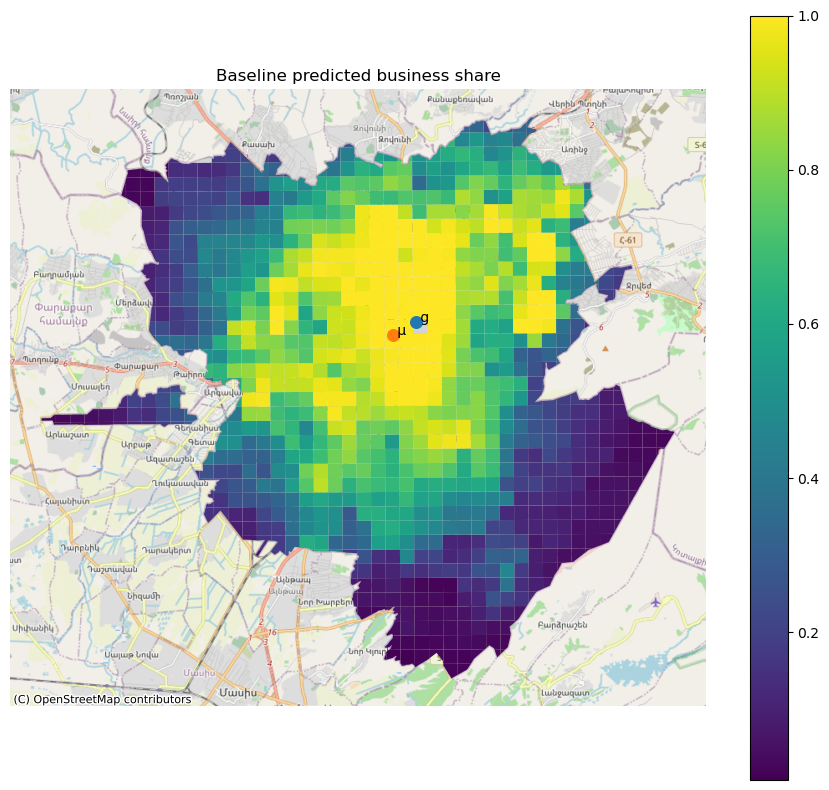


CF1 Transport: τ' = 0.8 · τ
New μ (x,y): 457875.4715188443 4446835.936946139
New |μ-g| (m): 1149.6896904595492


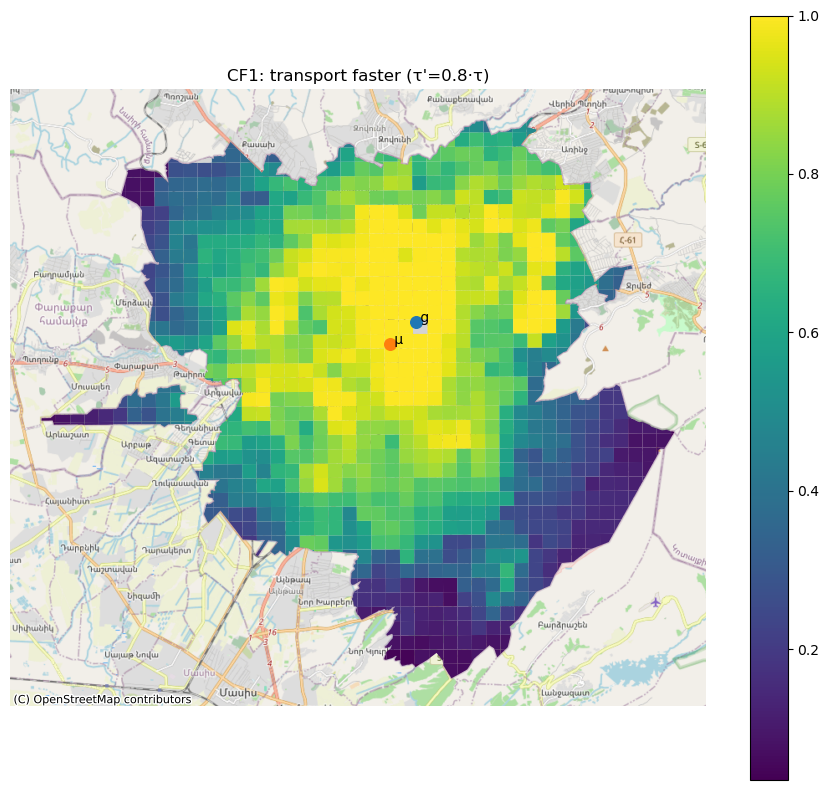


CF2 Heritage: +50% within 1000 m of g
New μ (x,y): 457956.1803119813 4447135.348690731
New |μ-g| (m): 912.2623530665892


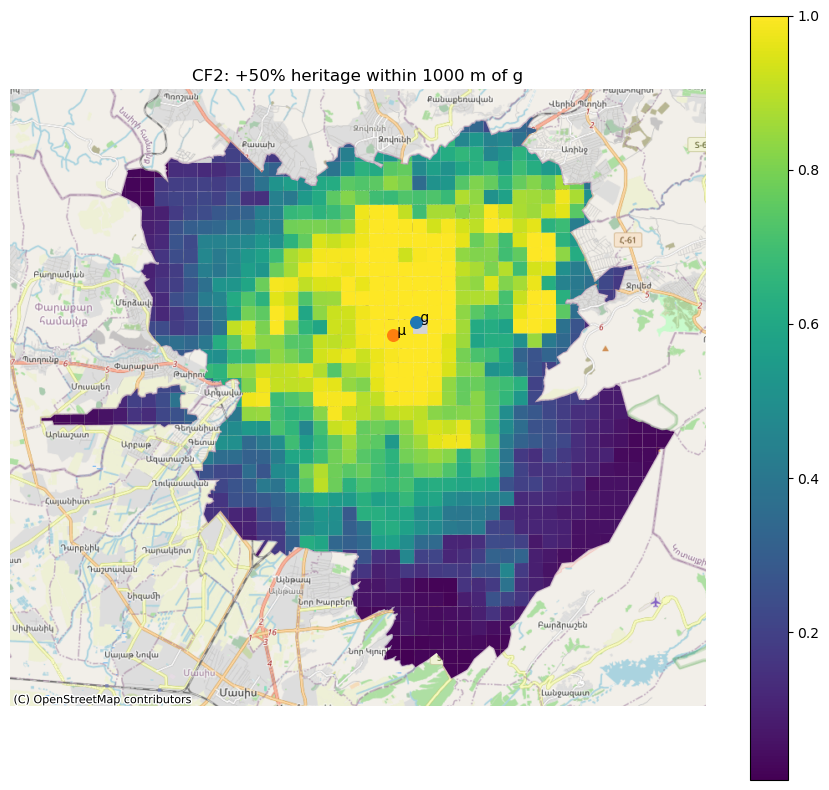


CF3 New g: Cascade (manual fallback if needed)
New μ (x,y): 457954.25821389246 4447179.766642396
New |μ-g_new| (m): 2136.701509877434


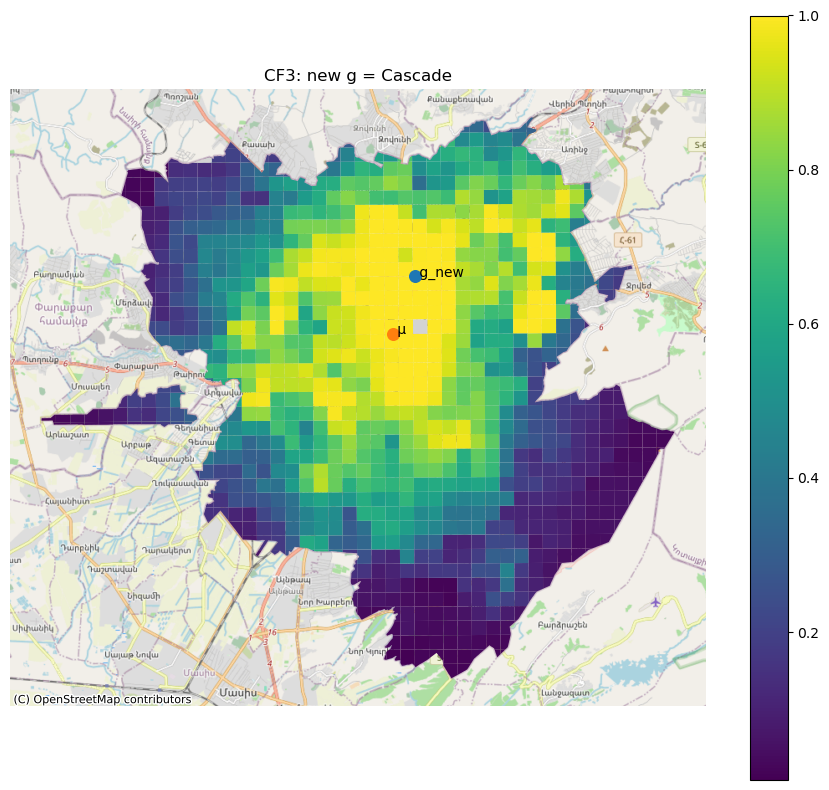


Saved counterfactual maps: data/yerevan_counterfactuals\counterfactual_results.gpkg


In [12]:
# FULL counterfactual runner (robust) for the 2D grid model with endogenous μ
# Fixes your geocoding failure by:
# - Trying multiple Nominatim queries
# - If all fail, falling back to manual lon/lat for g and g_new (recommended)
#
# Outputs:
# - new μ (x,y) and new |μ-g| for baseline + 3 counterfactuals
# - business share maps: s_base, s_cf_transport, s_cf_heritage, s_cf_newg
# - saves GeoPackage: data/yerevan_counterfactuals/counterfactual_results.gpkg
#
# Requirements:
#   pip install geopandas osmnx numpy pandas statsmodels matplotlib contextily shapely

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import statsmodels.api as sm
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

# -----------------------------
# INPUTS
# -----------------------------
ESTIMATED_GPKG = r"data/yerevan_model/yerevan_estimated_allocation.gpkg"
ESTIMATED_LAYER = "estimated_grid"

OUT_DIR = r"data/yerevan_counterfactuals"
OUT_GPKG = os.path.join(OUT_DIR, "counterfactual_results.gpkg")
OUT_LAYER = "cf_grid"

ZOOM_LEVEL = 12

# Baseline g label
G_BASE_QUERY_CANDIDATES = [
    "Republic Square, Yerevan, Armenia",
    "Republic Square, Yerevan",
    "Հանրապետության հրապարակ, Երևան",
]

# New g label (Cascade). Nominatim sometimes fails, so provide manual coords too.
G_NEW_QUERY_CANDIDATES = [
    "Cascade, Yerevan, Armenia",
    "Yerevan Cascade, Yerevan, Armenia",
    "Cafesjian Center for the Arts, Yerevan, Armenia",
    "Cafesjian Center for the Arts, Yerevan",
    "Կասկադ, Երևան",
]

# Manual fallback coordinates (lon, lat)
# These are approximate. If you want the exact point, adjust lon/lat here.
G_BASE_LONLAT_FALLBACK = (44.5126, 40.1776)   # Republic Square approx (lon, lat)
G_NEW_LONLAT_FALLBACK  = (44.5152, 40.1919)   # Cascade approx (lon, lat)

# Counterfactuals
TRANSPORT_FACTOR = 0.8
HERIT_RADIUS_M = 1000.0
HERIT_MULTIPLIER = 1.5

# μ fixed-point settings
MAX_ITERS = 30
TOL_M = 50.0

# Model A features
FEATURES_A = ["trav_tt_to_mu_min", "amen_dist_to_g_m", "amen_herit_density_500m", "pop_density_per_km2"]


# -----------------------------
# HELPERS
# -----------------------------
def ensure_needed_columns(df: gpd.GeoDataFrame):
    needed = ["trav_tt_to_mu_min", "amen_dist_to_g_m", "amen_herit_density_500m",
              "pop_density_per_km2", "y_business", "cx", "cy"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise RuntimeError(f"Missing required columns in estimated_grid: {missing}")

def point_from_lonlat_to_utm(lon: float, lat: float, epsg: int = 32638) -> Point:
    geom = Point(lon, lat)
    return gpd.GeoDataFrame(geometry=[geom], crs="EPSG:4326").to_crs(epsg=epsg).geometry.iloc[0]

def get_point_utm_robust(query_candidates, fallback_lonlat=None, epsg: int = 32638) -> Point:
    """
    Tries multiple queries via Nominatim through OSMnx.
    If all fail, uses fallback lon/lat.
    """
    # Be nice to Nominatim
    ox.settings.use_cache = True
    ox.settings.log_console = False
    ox.settings.timeout = 180
    # Provide a stable user-agent
    ox.settings.requests_kwargs = {"headers": {"User-Agent": "yerevan-urban-model/1.0"}}

    last_err = None
    for q in query_candidates:
        try:
            # Try polygon-based first, but it may fail for POIs
            try:
                gdf = ox.geocode_to_gdf(q)
                geom = gdf.geometry.iloc[0]
                if geom.geom_type in ["Polygon", "MultiPolygon"]:
                    geom = geom.centroid
                elif geom.geom_type != "Point":
                    geom = geom.representative_point()
                pt = gpd.GeoDataFrame(geometry=[geom], crs=gdf.crs).to_crs(epsg=epsg).geometry.iloc[0]
                return pt
            except Exception:
                # Fall back to point geocode
                lat, lon = ox.geocode(q)  # returns (lat, lon)
                return point_from_lonlat_to_utm(lon, lat, epsg=epsg)
        except Exception as e:
            last_err = e

    if fallback_lonlat is not None:
        lon, lat = fallback_lonlat
        return point_from_lonlat_to_utm(lon, lat, epsg=epsg)

    raise RuntimeError(f"All geocoding attempts failed. Last error: {last_err}")

def standardize_with_stats(X: pd.DataFrame, means: pd.Series, stds: pd.Series) -> pd.DataFrame:
    Z = X.copy()
    for c in X.columns:
        s = stds[c]
        if s == 0 or np.isnan(s):
            continue
        Z[c] = (Z[c] - means[c]) / s
    return Z

def fit_model_A(df: pd.DataFrame, features):
    est = df[["y_business"] + features].replace([np.inf, -np.inf], np.nan).dropna().copy()
    Xraw = est[features].astype(float)
    means = Xraw.mean()
    stds = Xraw.std().replace(0, 1.0)
    X = standardize_with_stats(Xraw, means, stds)
    X = sm.add_constant(X, has_constant="add")
    y = est["y_business"].astype(int)
    model = sm.Logit(y, X).fit(disp=False)
    return model, means, stds, est.index

def predict_share(model, means, stds, df: pd.DataFrame, features) -> pd.Series:
    Xraw = df[features].astype(float).replace([np.inf, -np.inf], np.nan)
    X = standardize_with_stats(Xraw, means, stds)
    X = sm.add_constant(X, has_constant="add")
    return model.predict(X)

def update_mu_from_shares(df: pd.DataFrame, share_col: str):
    p = df[share_col].to_numpy()
    valid = np.isfinite(p)
    p = p[valid]
    cx = df.loc[valid, "cx"].to_numpy()
    cy = df.loc[valid, "cy"].to_numpy()
    denom = p.sum()
    if denom <= 1e-9:
        raise RuntimeError("Predicted shares sum to ~0; cannot update μ.")
    mx = float((cx * p).sum() / denom)
    my = float((cy * p).sum() / denom)
    return mx, my

def fixed_point_mu(df: gpd.GeoDataFrame, model, means, stds, features, mu_init_xy, share_out_col):
    mx, my = mu_init_xy
    for _ in range(MAX_ITERS):
        df[share_out_col] = predict_share(model, means, stds, df, features)
        mx_new, my_new = update_mu_from_shares(df, share_out_col)
        shift = float(np.sqrt((mx_new - mx) ** 2 + (my_new - my) ** 2))
        mx, my = mx_new, my_new
        if shift < TOL_M:
            break
    return mx, my

def plot_map(gdf_utm: gpd.GeoDataFrame, col: str, title: str, pts=None):
    g3857 = gdf_utm.to_crs(epsg=3857)
    fig, ax = plt.subplots(1, 1, figsize=(9, 8))
    g3857.plot(
        column=col,
        ax=ax,
        legend=True,
        linewidth=0,
        missing_kwds={"color": "lightgrey", "label": "No data"},
    )
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=ZOOM_LEVEL)

    if pts:
        for (pt_utm, label) in pts:
            pt3857 = gpd.GeoSeries([pt_utm], crs="EPSG:32638").to_crs(epsg=3857).iloc[0]
            ax.scatter([pt3857.x], [pt3857.y], s=70)
            ax.text(pt3857.x, pt3857.y, f" {label}", fontsize=10)

    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


# -----------------------------
# MAIN
# -----------------------------
def main():
    os.makedirs(OUT_DIR, exist_ok=True)

    df = gpd.read_file(ESTIMATED_GPKG, layer=ESTIMATED_LAYER).to_crs("EPSG:32638")

    if "cx" not in df.columns or "cy" not in df.columns:
        df["cx"] = df.geometry.centroid.x
        df["cy"] = df.geometry.centroid.y

    ensure_needed_columns(df)

    # Robust g points with fallback lon/lat
    g_base = get_point_utm_robust(
        G_BASE_QUERY_CANDIDATES,
        fallback_lonlat=G_BASE_LONLAT_FALLBACK,
        epsg=32638
    )
    g_new = get_point_utm_robust(
        G_NEW_QUERY_CANDIDATES,
        fallback_lonlat=G_NEW_LONLAT_FALLBACK,
        epsg=32638
    )

    # Fit Model A
    modelA, meansA, stdsA, est_idx = fit_model_A(df, FEATURES_A)
    print("Model A fit on n =", len(est_idx))
    print(modelA.summary())

    # Baseline shares and μ
    df["s_base"] = predict_share(modelA, meansA, stdsA, df, FEATURES_A)
    mu0x, mu0y = update_mu_from_shares(df, "s_base")
    mu0 = Point(mu0x, mu0y)
    sep0 = float(mu0.distance(g_base))

    print("\nBaseline μ (x,y):", mu0x, mu0y)
    print("Baseline |μ-g| (m):", sep0)

    plot_map(df, "s_base", "Baseline predicted business share", pts=[(g_base, "g"), (mu0, "μ")])

    # CF1 transport
    cf1 = df.copy()
    cf1["trav_tt_to_mu_min"] = cf1["trav_tt_to_mu_min"] * TRANSPORT_FACTOR
    mu1x, mu1y = fixed_point_mu(cf1, modelA, meansA, stdsA, FEATURES_A, (mu0x, mu0y), "s_cf_transport")
    mu1 = Point(mu1x, mu1y)
    sep1 = float(mu1.distance(g_base))

    print("\nCF1 Transport: τ' =", TRANSPORT_FACTOR, "· τ")
    print("New μ (x,y):", mu1x, mu1y)
    print("New |μ-g| (m):", sep1)

    plot_map(cf1, "s_cf_transport", f"CF1: transport faster (τ'={TRANSPORT_FACTOR}·τ)", pts=[(g_base, "g"), (mu1, "μ")])

    # CF2 heritage upgrade
    cf2 = df.copy()
    dist_g = np.sqrt((cf2["cx"] - g_base.x) ** 2 + (cf2["cy"] - g_base.y) ** 2)
    mask = dist_g <= HERIT_RADIUS_M
    cf2.loc[mask, "amen_herit_density_500m"] = cf2.loc[mask, "amen_herit_density_500m"] * HERIT_MULTIPLIER

    mu2x, mu2y = fixed_point_mu(cf2, modelA, meansA, stdsA, FEATURES_A, (mu0x, mu0y), "s_cf_heritage")
    mu2 = Point(mu2x, mu2y)
    sep2 = float(mu2.distance(g_base))

    print("\nCF2 Heritage: +50% within", int(HERIT_RADIUS_M), "m of g")
    print("New μ (x,y):", mu2x, mu2y)
    print("New |μ-g| (m):", sep2)

    plot_map(cf2, "s_cf_heritage", f"CF2: +50% heritage within {int(HERIT_RADIUS_M)} m of g", pts=[(g_base, "g"), (mu2, "μ")])

    # CF3 new leisure center g
    cf3 = df.copy()
    cf3["amen_dist_to_g_m"] = np.sqrt((cf3["cx"] - g_new.x) ** 2 + (cf3["cy"] - g_new.y) ** 2)

    mu3x, mu3y = fixed_point_mu(cf3, modelA, meansA, stdsA, FEATURES_A, (mu0x, mu0y), "s_cf_newg")
    mu3 = Point(mu3x, mu3y)
    sep3 = float(mu3.distance(g_new))

    print("\nCF3 New g:", "Cascade (manual fallback if needed)")
    print("New μ (x,y):", mu3x, mu3y)
    print("New |μ-g_new| (m):", sep3)

    plot_map(cf3, "s_cf_newg", "CF3: new g = Cascade", pts=[(g_new, "g_new"), (mu3, "μ")])

    # Save combined layer
    out = df[["geometry", "s_base"]].copy()
    out["s_cf_transport"] = cf1["s_cf_transport"]
    out["s_cf_heritage"] = cf2["s_cf_heritage"]
    out["s_cf_newg"] = cf3["s_cf_newg"]

    # constants for reference
    out["mu_base_x"] = mu0x
    out["mu_base_y"] = mu0y
    out["sep_base_m"] = sep0

    out["mu_tr_x"] = mu1x
    out["mu_tr_y"] = mu1y
    out["sep_tr_m"] = sep1

    out["mu_h_x"] = mu2x
    out["mu_h_y"] = mu2y
    out["sep_h_m"] = sep2

    out["mu_newg_x"] = mu3x
    out["mu_newg_y"] = mu3y
    out["sep_newg_m"] = sep3

    out.to_file(OUT_GPKG, layer=OUT_LAYER, driver="GPKG")
    print("\nSaved counterfactual maps:", OUT_GPKG)


if __name__ == "__main__":
    main()
